## Introduction
This project will involve forecasting time series data related to median real estate prices in various zipcodes in order to answer the client's question: "What are the top 5 zipcodes for us to invest in?" This question is a bit vague, and will require some domain knowledge to answer. To approach this project, a CRISP-DM workflow will be followed.

## Business Understanding:
A couple things to immediately note about the question at hand:
<ol>
    <li>
        Whether the client is looking at investment in residential/commercial real estate (or both) is not established. Taking a look at the <a href='https://www.zillow.com/research/data/'>Zillow Research Page</a>, from which the data is sourced, reveals that the prices are in reference to residential properties. This is valuable to know, as it narrows the scope of consideration for market forces that might be in effect at any given time, and removes possibility of inconsistences of market type among the zipcodes.</li>
    <li>        
The time horizon for these investments is not defined. Shorter-term investments that could bring faster returns typically have more risk involved due to price volatility. Less volatile markets with stable growth are typically good targets for longer term investment. Diversification is generally accepted to be a good strategy in any investment portfolio, so it may be wise to consider some split between these two strategies. With real estate, one could assume that the holding period of the assets would be longer than, say, with stock investment, since real estate is less liquid. This might mean that a short holding period may be more like a year, and a longer holding period around 5 or even 10 years. More exposure to the data will reveal some strategic insights. It is also important to note that long-term real-estate investments can be leased in the short-term. Although it is not established whether the client is a landlord or property management company, these services can be provided by third parties, so for any type of investor holding real estate for years at a time, this is a good profit strategy. In all, logic would suggest that the strategy should be investing in properties which have strong expected growth over a time horizon, and leasing the property during that time horizon.</li></ol>
<br>
 Although the <a href='https://www.investopedia.com/articles/basics/04/022004.asp'>Efficient Market Hypothesis</a>, which states that market prices reflect all current available knowledge affecting the investment, has been shown to be demonstrably false (as indicated by the level of diversity in the returns of individual investors in markets), it is not completely without merit or unworthy of consideration. Especially when dealing with median prices for real estate in a region, such as this dataset, one can expect that a fair deal of knowledge about the future expectations for the real estate of that region is already factored into the averaged market price seen. Further, depending on the number of zipcodes in the dataset, doing individualized research to understand fundamental developments occuring in each may be unfeasible. However, if the list is narrowed down to a few, further investigation may be appropriate.<br>
 <br>
 Since models will have a range of values within the confidence interval, the low side may or may not be higher than the initial investment, a good way to narrow down the pool of zipcodes to consider might involve using the lower end of the confidence interval at a projection period of 5 years out, and seeing if it is higher than the initial investment, therefore showing good confidence that in a worst case scenario, the investor would not be likely to LOSE any money on the investment. Also, any losses may be offset by leasing the properties over the course of the investment period.<br>
 <br>
 Another filtering method that may be employed would be to find the average monthly return of each zipcode, and focus on those zipcodes which consistently outperformed in repeated sampling of random time windows. Since the data spans across the Great Recession, this would also indicate which zipcodes had real estate which was more resilient to the crisis, further justifying investor confidence.

## Data Understanding:
- The data to be used for this project has been made available in a .csv file 'zillow_data.csv' contained in this repository. The data is in Wide Format, meaning that the dates for the time series are the headers of columns. This means that the data will have to be melted using pandas in order to get it into Long Format, which will be necessary for modeling the time series.
- Further data about the zip codes may later be obtained from the internet, depending on the project's needs, after the list of potential investments has been considerably narrowed down.

In [1]:
# Importing the necessary libraries
import matplotlib.pyplot as plt
import my_functions as mf
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.stats.stattools as st

In [2]:
%load_ext autoreload
%autoreload 1
%aimport my_functions

In [3]:
# Plot styling
plt.style.use('ggplot')
from jupyterthemes import jtplot
jtplot.style()

In [4]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 11, 7

In [5]:
# Getting a look at the raw data
df = pd.read_csv('zillow_data.csv')
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


A question to answer immediately is whether the RegionID or RegionName represents the zip code of a region. A few quick google searches reveal that the RegionName column contains the zip codes.

In [6]:
# Getting the number of rows and columns
df.info(())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB


In [7]:
# We can see that there are a lot of rows, 14723, in the dataset.
# Checking to see if there is the same number of unique zip codes (RegionName)
df.RegionName.nunique()

14723

In [8]:
# We see that there are 14723 unique zip codes in the database. For clarity, I will rename
# the RegionName column to 'zipcode':
df.rename(columns={'RegionName':'zipcode'}, inplace=True)
df.head(15)

,RegionID,zipcode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500
5,91733,77084,Houston,TX,Houston,Harris,6,95000.0,95200.0,95400.0,...,157900,158700,160200,161900,162800,162800,162800,162900,163500,164300
6,61807,10467,New York,NY,New York,Bronx,7,152900.0,152700.0,152600.0,...,394400,400000,407300,411600,413200,414300,413900,411400,413200,417900
7,84640,60640,Chicago,IL,Chicago,Cook,8,216500.0,216700.0,216900.0,...,798000,787100,776100,774900,777900,777900,778500,780500,782800,782800
8,91940,77449,Katy,TX,Houston,Harris,9,95400.0,95600.0,95800.0,...,166800,167400,168400,169600,170900,172300,173300,174200,175400,176200
9,97564,94109,San Francisco,CA,San Francisco,San Francisco,10,766000.0,771100.0,776500.0,...,3767700,3763900,3775000,3799700,3793900,3778700,3770800,3763100,3779800,3813500


In [9]:
# It appears the SizeRank column is in ascending order, no description of this column is given
df.SizeRank

0            1
1            2
2            3
3            4
4            5
         ...  
14718    14719
14719    14720
14720    14721
14721    14722
14722    14723
Name: SizeRank, Length: 14723, dtype: int64

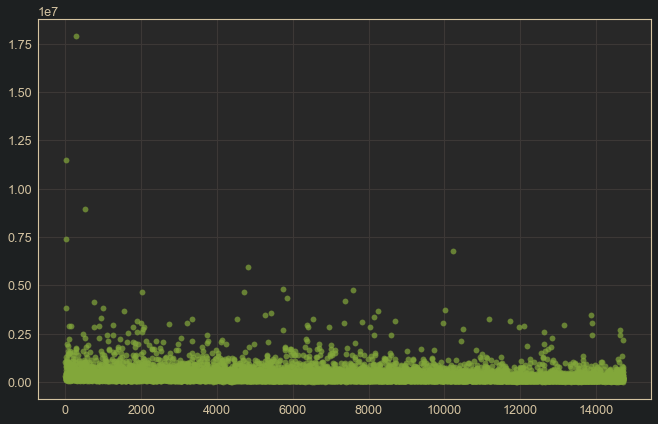

In [10]:
# Does SizeRank have any correlation to most recent prices?
plt.figure(figsize=(11,7))
plt.scatter(df.SizeRank, df['2018-04'], alpha=0.7);

In [11]:
# Althought the largest outliers in most recent prices fall in the earlier size ranks,
# there does not appear to be any significant correlation beyond that. This feature is probably
# not valuable.

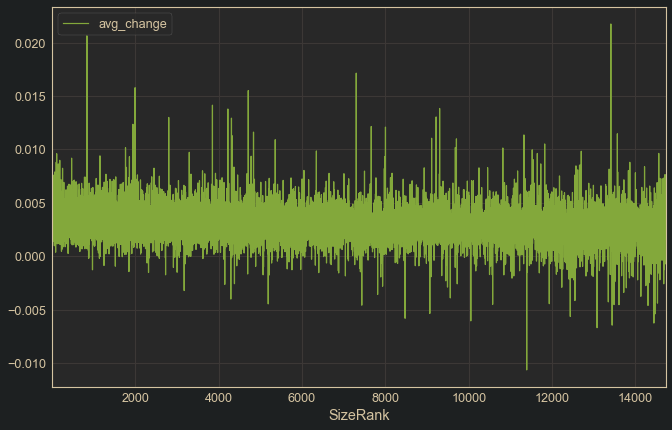

In [12]:
# I would like to see another relationship, that between SizeRank and the average monthly change
# of a zipcode over the whole time period
pct_change = df.set_index('SizeRank').drop(columns=['City', 
                                                   'State', 
                                                   'Metro', 
                                                   'CountyName', 
                                                   'RegionID',
                                                   'zipcode',]).T.pct_change()
avg_change = pd.DataFrame(pct_change.mean(), columns=['avg_change'])
avg_change.plot()

In [13]:
avg_change.head()

,avg_change
SizeRank,
1,0.004295
2,0.001215
3,0.001757
4,0.003682
5,0.001728


In [14]:
# Adding SizeRank back as a column for compatibility with functions
avg_change = avg_change.reset_index()
avg_change.head()

,SizeRank,avg_change
0,1,0.004295
1,2,0.001215
2,3,0.001757
3,4,0.003682
4,5,0.001728


In [15]:
# A look at the pearson correlation score for the two columns
avg_change.corr()

,SizeRank,avg_change
SizeRank,1.000000,-0.124774
avg_change,-0.124774,1.000000


Linear Regression for avg_change~SizeRank


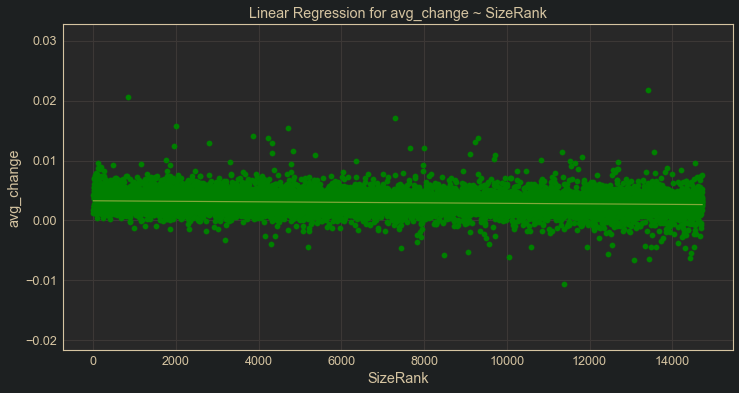

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             avg_change   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     232.8
Date:                Wed, 26 Aug 2020   Prob (F-statistic):           3.65e-52
Time:                        14:23:56   Log-Likelihood:                 75316.
No. Observations:               14723   AIC:                        -1.506e+05
Df Residuals:                   14721   BIC:                        -1.506e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0033   2.39e-05    136.700      0.000       0.003       0.003
SizeRank   -4.298e-08   2.82e-09    -15.258      0.000   -4.85e-08   -3.75e-08
==============================================================================
Omnibus:                     3405.502   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            52557.288
Skew:                           0.691   Prob(JB):                         0.00
Kurtosis:                      12.152   Cond. No.                     1.70e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.7e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Test for homoscedasticity of residuals:


,F_statistic,p_value
Goldfeld-Quandt,1.55542,1.12559e-71


Normality Test Results for ['residuals']:
-------------------------------------------------------------------------------------------


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1660: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 residuals 
 Statistic 
 0.496387 
 0.937573 
 
 
 p-value 
 0.000000 
 0.000000 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 residuals 
 114.871991 
 0.787 
 
 
 Jarque-Bera: 
 
 
 
 residuals 
 
 
 
 
 Statistic 
 52557.287540 
 
 
 p-value 
 0.000000 
 
 
 Skew 
 0.691120 
 
 
 Kurtosis 
 12.152223

Skew: 0.691120172619765
Kurtosis: 9.152222715093057


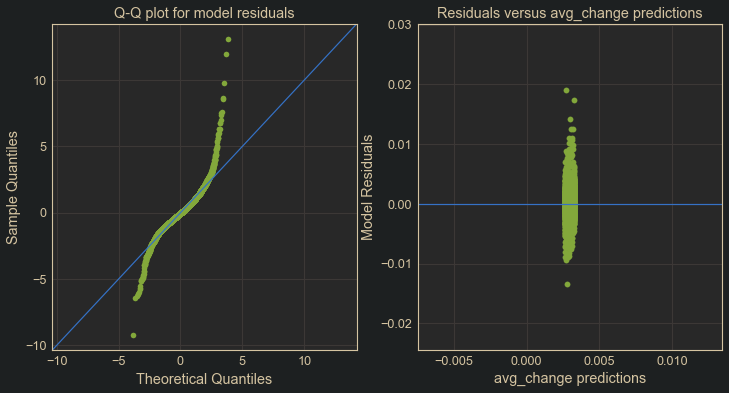

In [16]:
# There does appear to be a small amount of negative correlation between the SizeRank and the
# overall average monthly change of a zipcode. Let's test this relationship further with a
# linear regression.
mf.do_a_linreg(avg_change, 'SizeRank', 'avg_change')

In the above regression, the coefficient for the SizeRank feature's influence on a zipcode's overall average monthly return, though apparently significant, is extremely small, and negligible. Further, the assumptions of the regression were not met, and the R-squared was woeful anyhow. I will assume this feature is not valuable, and ignore it from here.

In [17]:
# Dropping the SizeRank column, as well as the RegionID
df.drop(columns=['RegionID', 'SizeRank'], inplace=True)

### Finding outperforming zip codes

In [18]:
# First using percent changes
pct_change = df.set_index('zipcode').drop(columns=['City', 
                                                   'State', 
                                                   'Metro', 
                                                   'CountyName'
                                                  ]).T.pct_change()

In [19]:
pct_change.head()

zipcode,60657,75070,77494,60614,79936,77084,10467,60640,77449,94109,...,3765,84781,12429,97028,12720,1338,3293,40404,81225,89155
1996-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-05,0.003591,0.005091,0.008555,0.005621,0.000000,0.002105,-0.001308,0.000924,0.002096,0.006658,...,-0.008663,0.002943,0.000000,0.002937,0.001600,-0.003171,-0.002157,0.003503,0.006803,-0.000567
1996-06,0.003280,-0.000844,0.000000,0.004392,0.000000,0.002101,-0.000655,0.000923,0.002092,0.007003,...,-0.008739,0.002201,-0.001277,0.001464,0.001597,-0.003181,-0.001081,0.003490,0.006757,-0.001134
1996-07,0.003269,-0.005492,-0.007069,0.002982,0.000000,0.003145,-0.001311,0.000461,0.003132,0.006954,...,-0.010076,0.002196,0.000000,0.000000,0.000000,-0.003191,-0.002165,0.003478,0.006711,-0.000568
1996-08,0.002666,-0.008921,-0.011391,0.001784,0.001294,0.002090,-0.000656,0.000461,0.003122,0.006906,...,-0.008906,0.001461,-0.001279,-0.000731,0.000000,-0.003202,-0.001085,0.005199,0.006667,-0.000568


Median for 60657: 0.004016387138366273
Mean for 60657: 0.0042950361785796054
Normality Test Results for [60657]:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 60657 
 Statistic 
 4.952419e-01 
 0.988272 
 
 
 p-value 
 2.559368e-60 
 0.030556 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 60657 
 0.970426 
 0.776 
 
 
 Jarque-Bera: 
 
 
 
 60657 
 
 
 
 
 Statistic 
 1.042787 
 
 
 p-value 
 0.593693 
 
 
 Skew 
 -0.078841 
 
 
 Kurtosis 
 2.735547

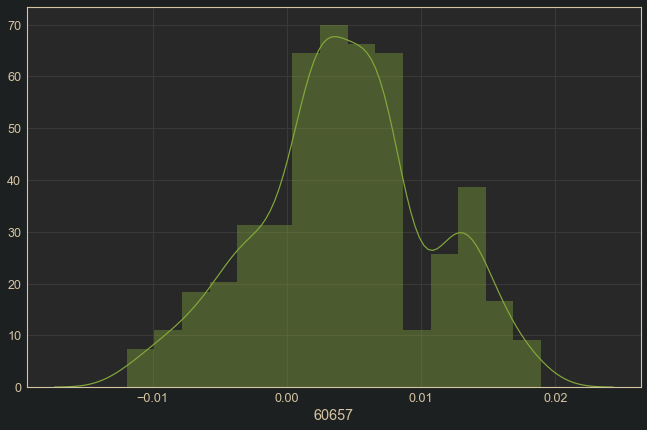

Median for 75070: 0.002254961175804371
Mean for 75070: 0.0012151485394771924
Normality Test Results for [75070]:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 75070 
 Statistic 
 4.897961e-01 
 9.421729e-01 
 
 
 p-value 
 6.380644e-59 
 1.105654e-08 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 75070 
 5.644502 
 0.776 
 
 
 Jarque-Bera: 
 
 
 
 75070 
 
 
 
 
 Statistic 
 4.307768e+01 
 
 
 p-value 
 4.423863e-10 
 
 
 Skew 
 -5.530765e-01 
 
 
 Kurtosis 
 4.640908e+00

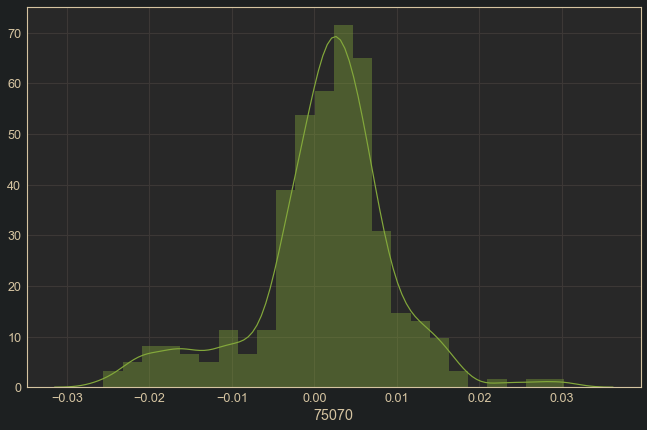

Median for 77494: 0.0013373421057769619
Mean for 77494: 0.00175682453435862
Normality Test Results for [77494]:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 77494 
 Statistic 
 4.886697e-01 
 9.440606e-01 
 
 
 p-value 
 1.233816e-58 
 1.722436e-08 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 77494 
 4.750811 
 0.776 
 
 
 Jarque-Bera: 
 
 
 
 77494 
 
 
 
 
 Statistic 
 4.542569e+01 
 
 
 p-value 
 1.367529e-10 
 
 
 Skew 
 6.968922e-02 
 
 
 Kurtosis 
 5.027358e+00

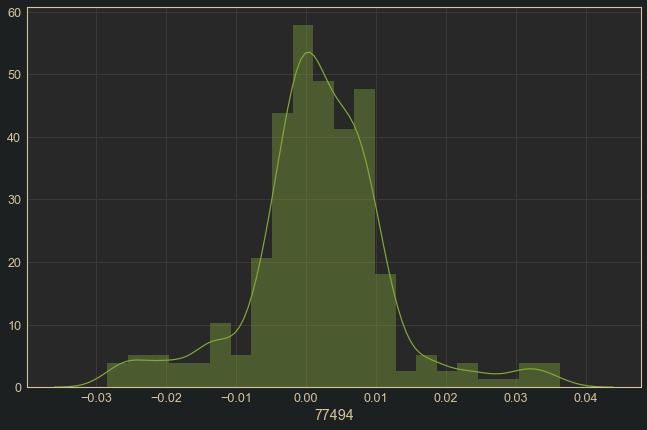

Median for 60614: 0.003648611561309134
Mean for 60614: 0.0036818024757118103
Normality Test Results for [60614]:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 60614 
 Statistic 
 4.945085e-01 
 0.987546 
 
 
 p-value 
 3.957235e-60 
 0.022071 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 60614 
 0.888871 
 0.776 
 
 
 Jarque-Bera: 
 
 
 
 60614 
 
 
 
 
 Statistic 
 1.131290 
 
 
 p-value 
 0.567994 
 
 
 Skew 
 -0.154046 
 
 
 Kurtosis 
 2.910981

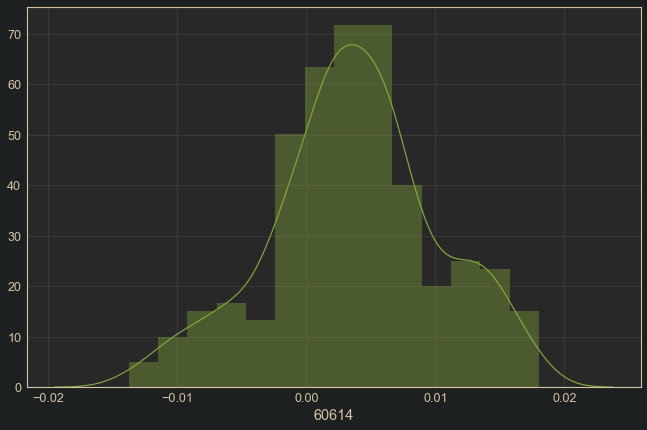

Median for 79936: 0.0012714809964918805
Mean for 79936: 0.001728273319979783
Normality Test Results for [79936]:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 79936 
 Statistic 
 4.954825e-01 
 9.577079e-01 
 
 
 p-value 
 2.218038e-60 
 5.729984e-07 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 79936 
 3.097394 
 0.776 
 
 
 Jarque-Bera: 
 
 
 
 79936 
 
 
 
 
 Statistic 
 3.524575e+01 
 
 
 p-value 
 2.220667e-08 
 
 
 Skew 
 7.404179e-01 
 
 
 Kurtosis 
 4.005626e+00

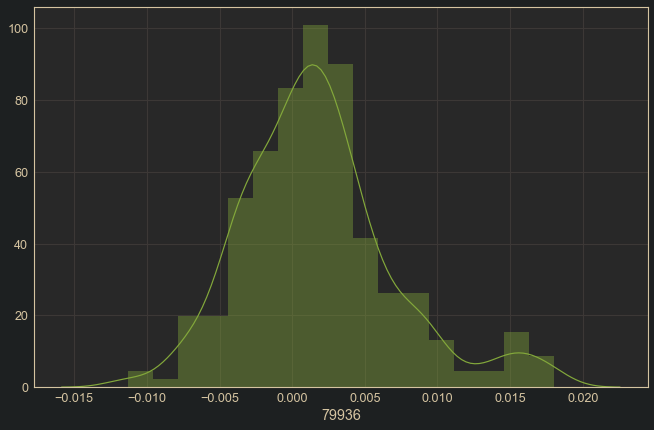

In [20]:
# Checking how normal the distributions are to determine if mean is a reliable statistic to use
for i in range(5):
    subset = pct_change.iloc[:, i]
    sns.distplot(subset.dropna())
    print("Median for {}: {}".format(subset.name, subset.median()))
    print("Mean for {}: {}".format(subset.name, subset.mean()))
    mf.check_normality(subset, [subset.name])
    plt.show()

In [21]:
# We can see that while some of the zipcodes have normally distributed percent changes,
# some do not, so median may not be the best comparison, and median may be more robust.
# First, I'd like to see how the distributions of log returns look
log_rets = np.log(df.set_index('zipcode').drop(columns=['City', 
                                                   'State', 
                                                   'Metro', 
                                                   'CountyName'
                                                  ]).T).diff()
log_rets.head()

zipcode,60657,75070,77494,60614,79936,77084,10467,60640,77449,94109,...,3765,84781,12429,97028,12720,1338,3293,40404,81225,89155
1996-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-05,0.003584,0.005078,0.008519,0.005606,0.000000,0.002103,-0.001309,0.000923,0.002094,0.006636,...,-0.008701,0.002939,0.000000,0.002933,0.001599,-0.003176,-0.002160,0.003497,0.006780,-0.000567
1996-06,0.003274,-0.000845,0.000000,0.004382,0.000000,0.002099,-0.000655,0.000923,0.002090,0.006979,...,-0.008777,0.002199,-0.001278,0.001463,0.001596,-0.003186,-0.001082,0.003484,0.006734,-0.001135
1996-07,0.003264,-0.005507,-0.007094,0.002977,0.000000,0.003140,-0.001311,0.000461,0.003127,0.006930,...,-0.010127,0.002194,0.000000,0.000000,0.000000,-0.003197,-0.002167,0.003472,0.006689,-0.000568
1996-08,0.002662,-0.008961,-0.011456,0.001782,0.001293,0.002088,-0.000656,0.000461,0.003117,0.006883,...,-0.008946,0.001460,-0.001280,-0.000731,0.000000,-0.003207,-0.001085,0.005186,0.006645,-0.000568


Median for 60657: 0.004008342975265755
Mean for 60657: 0.004265745529291026
Normality Test Results for [60657]:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 60657 
 Statistic 
 4.952133e-01 
 0.988135 
 
 
 p-value 
 2.603280e-60 
 0.028736 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 60657 
 0.971525 
 0.776 
 
 
 Jarque-Bera: 
 
 
 
 60657 
 
 
 
 
 Statistic 
 1.129386 
 
 
 p-value 
 0.568535 
 
 
 Skew 
 -0.095309 
 
 
 Kurtosis 
 2.742442

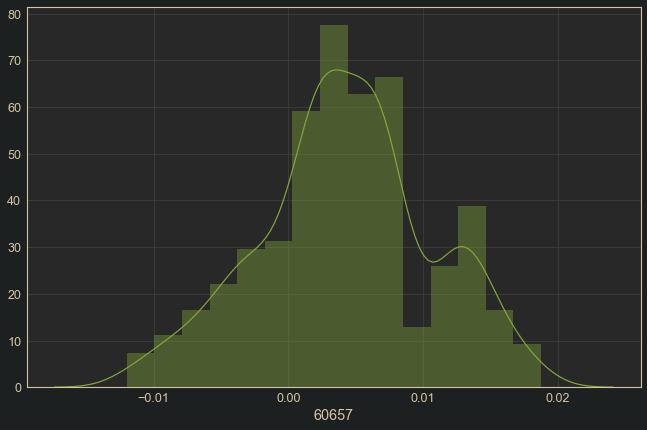

Median for 75070: 0.00225241976995072
Mean for 75070: 0.0011794334265765088
Normality Test Results for [75070]:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 75070 
 Statistic 
 4.896633e-01 
 9.404321e-01 
 
 
 p-value 
 6.897024e-59 
 7.403229e-09 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 75070 
 5.807307 
 0.776 
 
 
 Jarque-Bera: 
 
 
 
 75070 
 
 
 
 
 Statistic 
 4.543445e+01 
 
 
 p-value 
 1.361552e-10 
 
 
 Skew 
 -5.946513e-01 
 
 
 Kurtosis 
 4.648018e+00

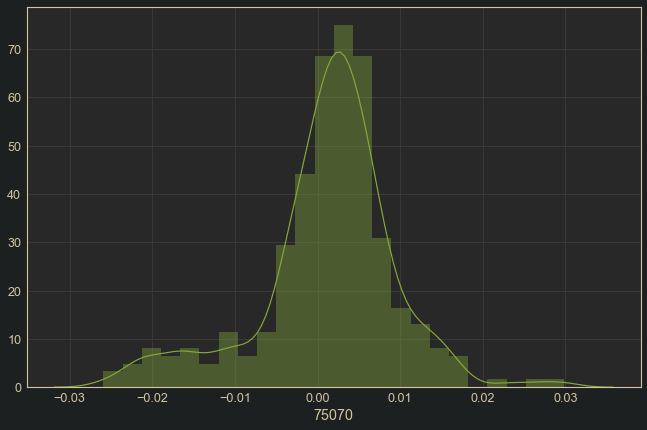

Median for 77494: 0.0013364486127782627
Mean for 77494: 0.0017037087021628033
Normality Test Results for [77494]:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 77494 
 Statistic 
 4.885057e-01 
 9.443247e-01 
 
 
 p-value 
 1.357920e-58 
 1.833962e-08 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 77494 
 4.774342 
 0.776 
 
 
 Jarque-Bera: 
 
 
 
 77494 
 
 
 
 
 Statistic 
 4.384197e+01 
 
 
 p-value 
 3.018825e-10 
 
 
 Skew 
 8.646898e-03 
 
 
 Kurtosis 
 4.996330e+00

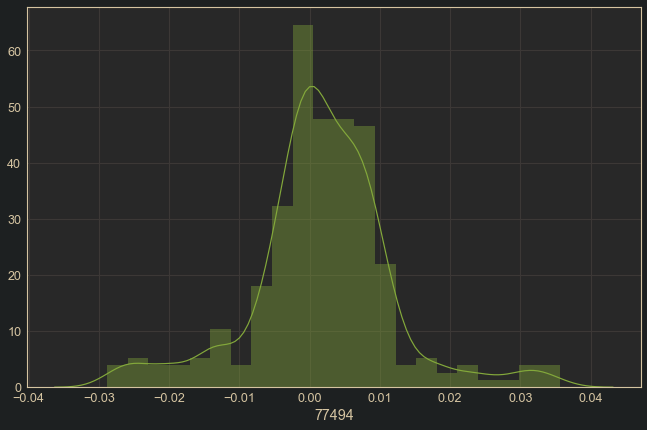

Median for 60614: 0.0036419698370986353
Mean for 60614: 0.003654124445246147
Normality Test Results for [60614]:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 60614 
 Statistic 
 4.944704e-01 
 0.987231 
 
 
 p-value 
 4.047864e-60 
 0.019177 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 60614 
 0.901185 
 0.776 
 
 
 Jarque-Bera: 
 
 
 
 60614 
 
 
 
 
 Statistic 
 1.373603 
 
 
 p-value 
 0.503183 
 
 
 Skew 
 -0.172390 
 
 
 Kurtosis 
 2.922544

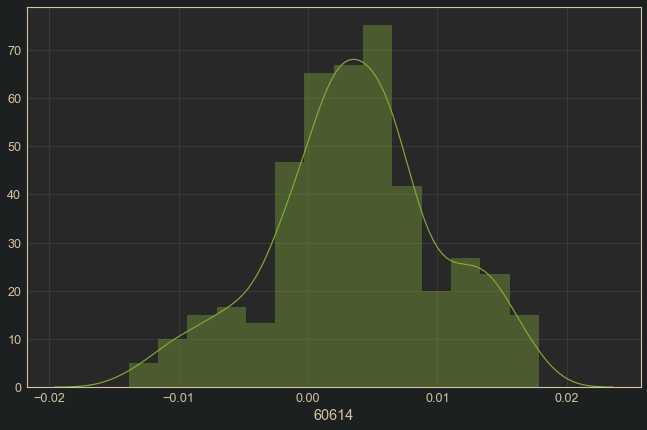

Median for 79936: 0.0012706733330958286
Mean for 79936: 0.0017129557090425275
Normality Test Results for [79936]:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 79936 
 Statistic 
 4.954567e-01 
 9.591054e-01 
 
 
 p-value 
 2.252322e-60 
 8.491392e-07 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 79936 
 3.006986 
 0.776 
 
 
 Jarque-Bera: 
 
 
 
 79936 
 
 
 
 
 Statistic 
 3.334479e+01 
 
 
 p-value 
 5.744751e-08 
 
 
 Skew 
 7.210552e-01 
 
 
 Kurtosis 
 3.975532e+00

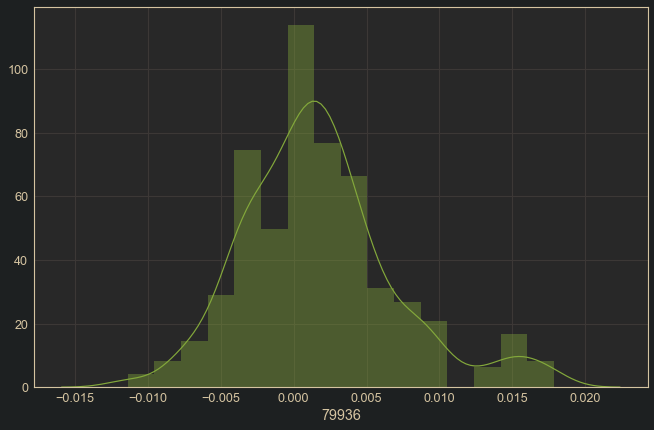

In [22]:
for i in range(5):
    subset = log_rets.iloc[:, i]
    sns.distplot(subset.dropna())
    print("Median for {}: {}".format(subset.name, subset.median()))
    print("Mean for {}: {}".format(subset.name, subset.mean()))
    mf.check_normality(subset, [subset.name])
    plt.show()

In [23]:
# We can see that this didn't fix the normality of the zipcodes. I will use median to
# compare their performance. I will use percentage changes
medians = pct_change.median()
medians.head()

zipcode
60657    0.004016
75070    0.002255
77494    0.001337
60614    0.003649
79936    0.001271
dtype: float64

In [24]:
# Now I'd like to look at the 10 best performers
ten_best = medians.sort_values(ascending=False).iloc[:10]
ten_best

zipcode
27980    0.023173
30032    0.019451
49636    0.018076
80216    0.016942
89030    0.016561
30288    0.014827
43206    0.014523
94621    0.014402
29405    0.013652
89512    0.013589
dtype: float64

I now have a list of the ten best performing zip codes according to their median monthly returns over the time period. I will return to this later, first I would like to see how the market behaved as a whole.

### Looking at the whole real estate market within the data
Since there are so many individual zipcodes, it will be useful to do some investigation with a more broad view by taking the average of the median sale prices of all the zipcodes for each month. This will give us an overall view of what generally happened with the market over the time period.

Median for 1996-04: 99500.0
Mean for 1996-04: 118299.12306343175
Normality Test Results for ['1996-04']:
-------------------------------------------------------------------------------------------


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1660: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 1996-04 
 Statistic 
 1.0 
 0.669048 
 
 
 p-value 
 0.0 
 0.000000 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 1996-04 
 704.744235 
 0.787 
 
 
 Jarque-Bera: 
 
 
 
 1996-04 
 
 
 
 
 Statistic 
 3.184048e+07 
 
 
 p-value 
 0.000000e+00 
 
 
 Skew 
 8.186575e+00 
 
 
 Kurtosis 
 2.387458e+02

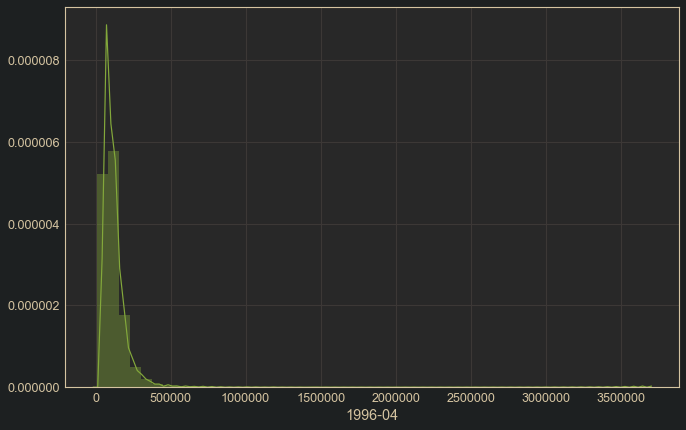

Median for 1996-05: 99500.0
Mean for 1996-05: 118419.0441391406
Normality Test Results for ['1996-05']:
-------------------------------------------------------------------------------------------


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1660: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 1996-05 
 Statistic 
 1.0 
 0.667243 
 
 
 p-value 
 0.0 
 0.000000 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 1996-05 
 709.007375 
 0.787 
 
 
 Jarque-Bera: 
 
 
 
 1996-05 
 
 
 
 
 Statistic 
 3.321174e+07 
 
 
 p-value 
 0.000000e+00 
 
 
 Skew 
 8.277905e+00 
 
 
 Kurtosis 
 2.437801e+02

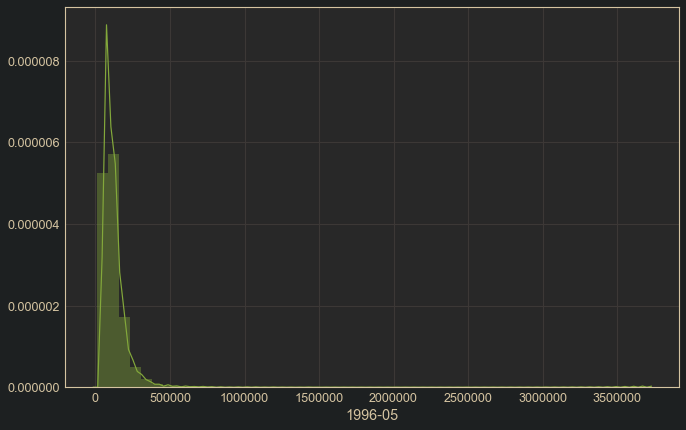

Median for 1996-06: 99700.0
Mean for 1996-06: 118537.42326805028
Normality Test Results for ['1996-06']:
-------------------------------------------------------------------------------------------


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1660: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 1996-06 
 Statistic 
 1.0 
 0.665485 
 
 
 p-value 
 0.0 
 0.000000 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 1996-06 
 713.330173 
 0.787 
 
 
 Jarque-Bera: 
 
 
 
 1996-06 
 
 
 
 
 Statistic 
 3.449232e+07 
 
 
 p-value 
 0.000000e+00 
 
 
 Skew 
 8.362241e+00 
 
 
 Kurtosis 
 2.483884e+02

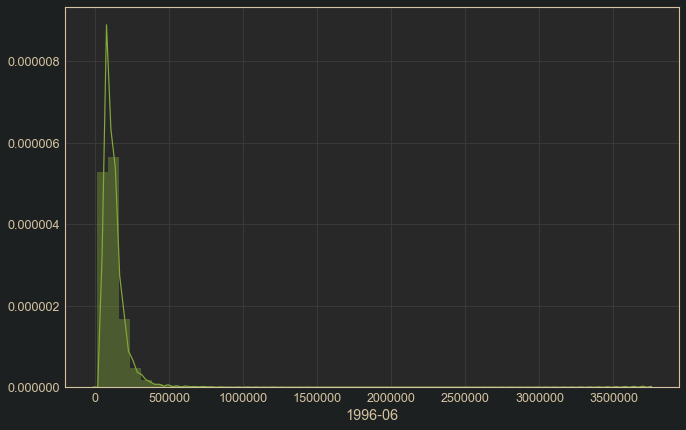

Median for 1996-07: 99700.0
Mean for 1996-07: 118653.06927798889
Normality Test Results for ['1996-07']:
-------------------------------------------------------------------------------------------


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1660: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 1996-07 
 Statistic 
 1.0 
 0.66371 
 
 
 p-value 
 0.0 
 0.00000 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 1996-07 
 717.804874 
 0.787 
 
 
 Jarque-Bera: 
 
 
 
 1996-07 
 
 
 
 
 Statistic 
 3.577506e+07 
 
 
 p-value 
 0.000000e+00 
 
 
 Skew 
 8.445455e+00 
 
 
 Kurtosis 
 2.529192e+02

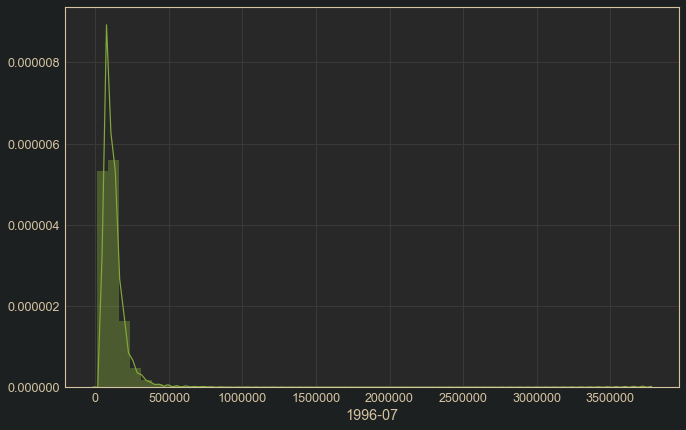

Median for 1996-08: 99800.0
Mean for 1996-08: 118780.25431160479
Normality Test Results for ['1996-08']:
-------------------------------------------------------------------------------------------


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1660: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 1996-08 
 Statistic 
 1.0 
 0.661852 
 
 
 p-value 
 0.0 
 0.000000 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 1996-08 
 722.401212 
 0.787 
 
 
 Jarque-Bera: 
 
 
 
 1996-08 
 
 
 
 
 Statistic 
 3.718596e+07 
 
 
 p-value 
 0.000000e+00 
 
 
 Skew 
 8.534637e+00 
 
 
 Kurtosis 
 2.578099e+02

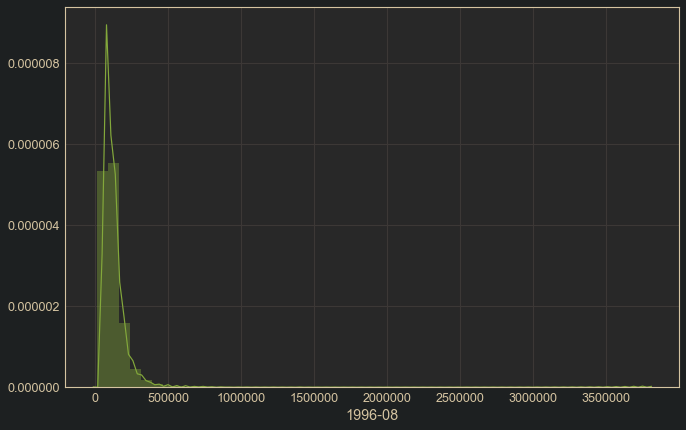

In [68]:
# Checking to see if mean is a reliable statistic:
datezips = df.set_index('zipcode').drop(columns=['City', 'State', 'Metro', 'CountyName'])
for i in range(5):
    subset = datezips.iloc[:, i]
    sns.distplot(subset.dropna())
    print("Median for {}: {}".format(subset.name, subset.median()))
    print("Mean for {}: {}".format(subset.name, subset.mean()))
    mf.check_normality(subset, [subset.name])
    plt.show()

Median for 1996-04: 11.507912923146684
Mean for 1996-04: 11.514263656083454
Normality Test Results for ['1996-04']:
-------------------------------------------------------------------------------------------


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1660: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 1996-04 
 Statistic 
 1.0 
 9.964508e-01 
 
 
 p-value 
 0.0 
 1.173114e-17 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 1996-04 
 5.471796 
 0.787 
 
 
 Jarque-Bera: 
 
 
 
 1996-04 
 
 
 
 
 Statistic 
 2.592146e+02 
 
 
 p-value 
 5.155377e-57 
 
 
 Skew 
 1.697598e-01 
 
 
 Kurtosis 
 3.582543e+00

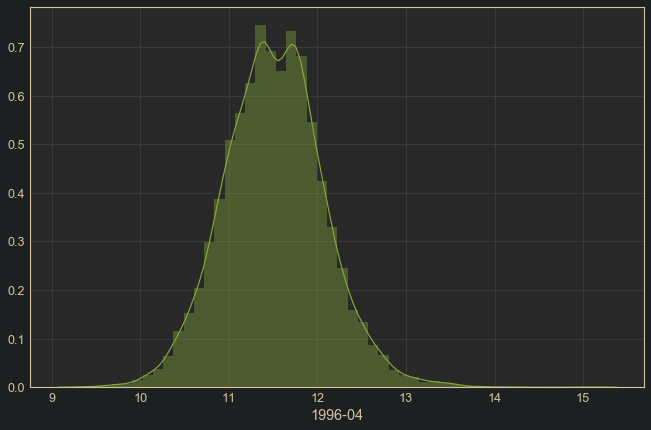

Median for 1996-05: 11.507912923146684
Mean for 1996-05: 11.515620114910819
Normality Test Results for ['1996-05']:
-------------------------------------------------------------------------------------------


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1660: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 1996-05 
 Statistic 
 1.0 
 9.963446e-01 
 
 
 p-value 
 0.0 
 5.902393e-18 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 1996-05 
 5.646196 
 0.787 
 
 
 Jarque-Bera: 
 
 
 
 1996-05 
 
 
 
 
 Statistic 
 2.680339e+02 
 
 
 p-value 
 6.268676e-59 
 
 
 Skew 
 1.748670e-01 
 
 
 Kurtosis 
 3.589732e+00

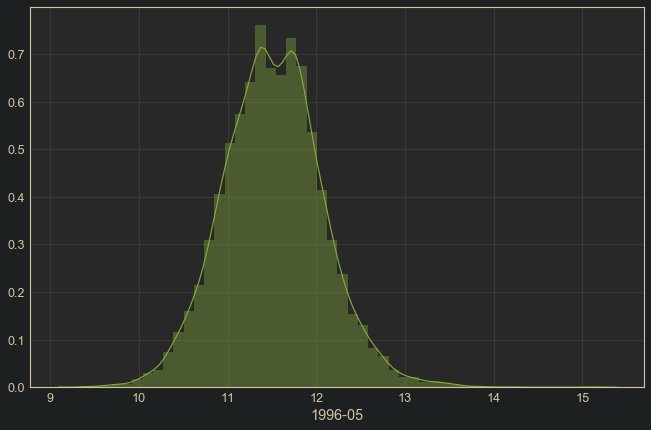

Median for 1996-06: 11.50992095594993
Mean for 1996-06: 11.516948575182408
Normality Test Results for ['1996-06']:
-------------------------------------------------------------------------------------------


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1660: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 1996-06 
 Statistic 
 1.0 
 9.962552e-01 
 
 
 p-value 
 0.0 
 3.346901e-18 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 1996-06 
 5.833936 
 0.787 
 
 
 Jarque-Bera: 
 
 
 
 1996-06 
 
 
 
 
 Statistic 
 2.773738e+02 
 
 
 p-value 
 5.875499e-61 
 
 
 Skew 
 1.800722e-01 
 
 
 Kurtosis 
 3.597306e+00

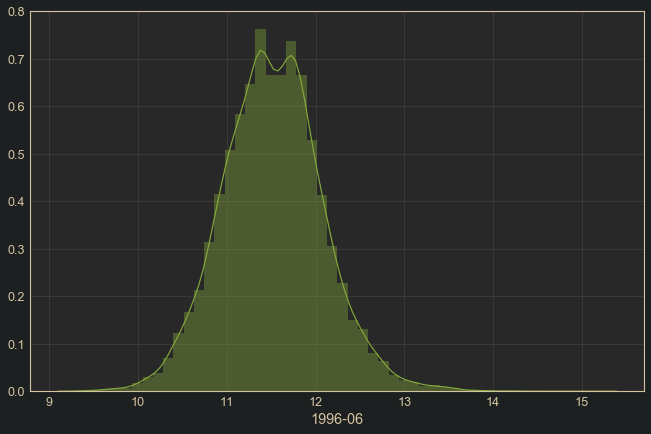

Median for 1996-07: 11.50992095594993
Mean for 1996-07: 11.518235757662946
Normality Test Results for ['1996-07']:
-------------------------------------------------------------------------------------------


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1660: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 1996-07 
 Statistic 
 1.0 
 9.961358e-01 
 
 
 p-value 
 0.0 
 1.591792e-18 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 1996-07 
 6.034485 
 0.787 
 
 
 Jarque-Bera: 
 
 
 
 1996-07 
 
 
 
 
 Statistic 
 2.870832e+02 
 
 
 p-value 
 4.577968e-63 
 
 
 Skew 
 1.854644e-01 
 
 
 Kurtosis 
 3.604913e+00

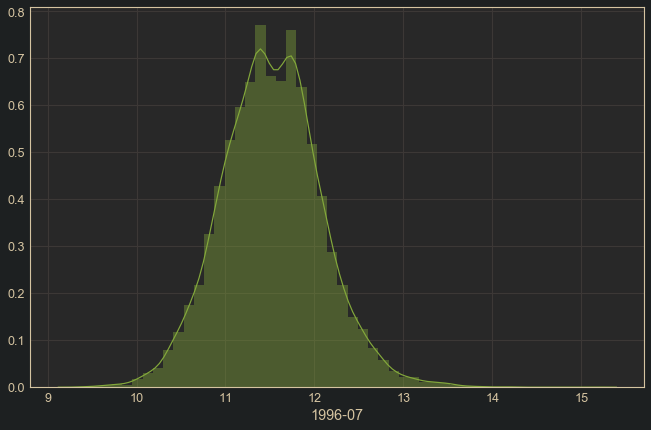

Median for 1996-08: 11.510923462299555
Mean for 1996-08: 11.519575746755715
Normality Test Results for ['1996-08']:
-------------------------------------------------------------------------------------------


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1660: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 1996-08 
 Statistic 
 1.0 
 9.960376e-01 
 
 
 p-value 
 0.0 
 8.740750e-19 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 1996-08 
 6.244039 
 0.787 
 
 
 Jarque-Bera: 
 
 
 
 1996-08 
 
 
 
 
 Statistic 
 2.970940e+02 
 
 
 p-value 
 3.067993e-65 
 
 
 Skew 
 1.905442e-01 
 
 
 Kurtosis 
 3.613055e+00

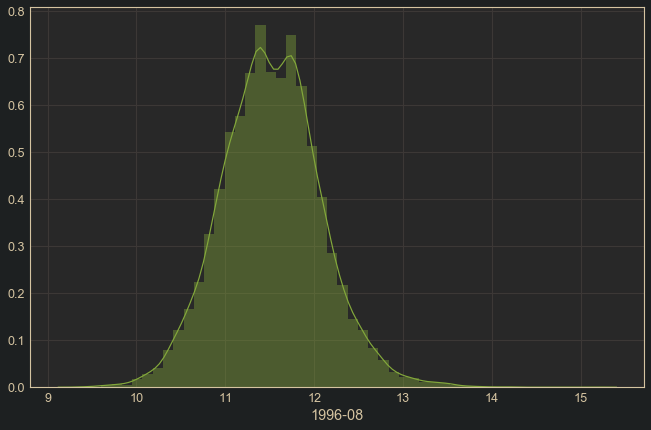

In [69]:
# We can see the prices among the zipcodes for each month are heavily positively skewed,
# log transformations may help this, but it may be more appropriate to use median values.
# Looking at the effect of log transformations:
for i in range(5):
    subset = np.log(datezips.iloc[:, i])
    sns.distplot(subset.dropna())
    print("Median for {}: {}".format(subset.name, subset.median()))
    print("Mean for {}: {}".format(subset.name, subset.mean()))
    mf.check_normality(subset, [subset.name])
    plt.show()

In [ ]:
# It looks as though the log transformations have made the median prices for each zip code
# per month much more normal. The tests are still rejecting the null-hypothesis of normality,
# but as the warnings above make clear, this may be (and probably is) due to the very large
# sample size of 14k+ zip codes. Looking at the median and means from this, we can see that
# they are all very similar, meaning the distribution is centered, also indicated by the
# relatively low skew. Since I will ultimately be modeling log returns, which are differenced
# log values of the sales, I will use the medians rather than the log means so that I'm still
# looking at dollar values, and I don't end up with the logs of logs.

In [25]:
# Getting a series of means for each month
medians = df.set_index('zipcode').drop(columns=['City', 'State', 'Metro', 'CountyName']).median()
medians

1996-04     99500.0
1996-05     99500.0
1996-06     99700.0
1996-07     99700.0
1996-08     99800.0
             ...   
2017-12    193400.0
2018-01    194100.0
2018-02    195000.0
2018-03    196700.0
2018-04    198100.0
Length: 265, dtype: float64

In [26]:
# Setting index to datetime format and checking result
medians.index = pd.to_datetime(medians.index, format='%Y-%m')
medians.index

DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', length=265, freq=None)

In [27]:
# Checking for any null values
print("Number of missing values:", medians.isna().sum())

Number of missing values: 0


In [28]:
medians = pd.DataFrame(medians)
medians.columns = ['medianPrice']
medians.head()

,medianPrice
1996-04-01,99500.0
1996-05-01,99500.0
1996-06-01,99700.0
1996-07-01,99700.0
1996-08-01,99800.0


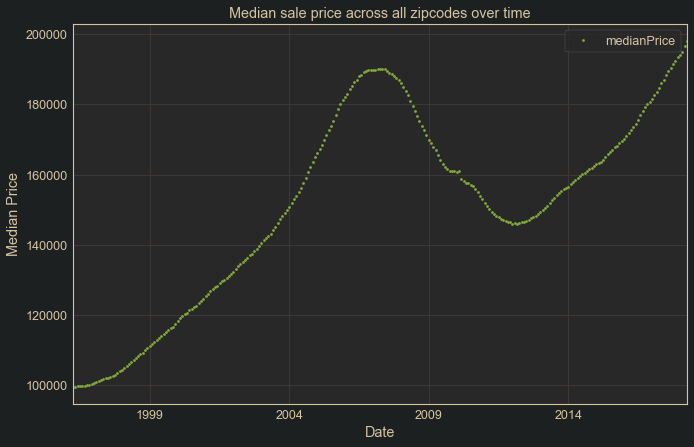

In [29]:
medians.plot(style='.b', figsize=(11,7))
plt.title("Median sale price across all zipcodes over time")
plt.xlabel("Date")
plt.ylabel("Median Price");

Above we can see no clear intra-year seasonality, but we definitely do see a pattern. It is a reminder that the housing market crashed in the [Subprime Mortgage Crisis](https://en.wikipedia.org/wiki/Subprime_mortgage_crisis) between 2007 and 2010, due to too many subprime mortgages being written out by banks (which they then sold on the securities market), many of which were ultimately foreclosed on. After the dip, we see another period of price inflation, but can we expect to see another "bubble pop" in another 5 years or so? That would have to consider whether the circumstances that led to the 2008 crash were truly unique, or whether there is a cyclic period of deflation that is known to happen even without questionable banking practices occuring in a widespread fashion. More historical data would be helpful to look for such a recurring trend, but is not available in the dataset. Another important consideration is that the data only goes through April of 2018, and that it is currently the end of July 2020, so the pattern may already be changing, if only we had more data to show it.<br>
<br>
Turning to outside research, an <a href='https://www.investopedia.com/investing/next-housing-recession-2020-predicts-zillow/'>article</a> posted in investopedia.com on October 2, 2019, states that researchers at Zillow (the same company that provided the data being used) predicted the next housing recession would manifest itself in 2020, though not for the same reasons as the 2008 crash. Their concerns were instead focused on rising federal interest rates, which would lead to mortgages being more expensive for potential homebuyers, potentially driving them out of the market. The article mentioned that very low unemployment, steady economic growth, and limited housing supply were overshadowing those concerns at the time of the research.<br>
<br>
There are some important things to mention in response to this. First is that around the time the article was written, the fed began to reduce interest rates. Then, in 2020, the Covid-19 pandemic struck and the federal interest rates plummeted to 0.25%, whereas they had been close to 2% when the article was published. This can be seen in the chart below:

<u>Historic Fed Interest Rates:</u>
![Historic Fed Interest Rates](images/fed_rates_chart.png)

This would mean that interest rates will likely not be the leading factor in a housing market recession, if it were to happen this year. Instead, vast unemployment and financial hardship due to the virus will be likely to drive housing prices down. Thus, though the reasoning may be different, it is not unlikely to see a declining housing market in 2020. This is another good reason to determine the zipcodes which were most resilient during the last downturn.<br>
<br>
A more recent <a href=https://www.redfin.com/blog/charting-coronavirus-housing-market-trends/>article</a> posted on Redfin.com corroborates the theory of another downturn occurring due to the pandemic. It shows that year-on-year price growth has indeed stagnated amidst the Covid-19 pandemic. The article mentions that lagged competition has given buyers more room to negotiate better prices, but stresses that sellers are not yet willing to reduce prices, knowing that supply is still low. This is summed up in a quote from Redfin agent David Palmer: "There’s fear on both sides. We have a bunch of buyers who want 40,000 dollar price reductions or credit that really should have been 15,000 dollars to 20,000 dollars. We’re calling it the ‘coronavirus credit’. I’d say it is getting a little closer to a level playing field, but sellers know that inventory is low and they’re trying to stick to their guns."

A further update to this line of thinking is the current eviction crisis. Homeowners may be looking to sell properties if they cannot find stable tenants to occupy them during the crisis, and this may lead to a surplus in supply, and a decrease in demand, leading to lower prices over the next year at least.

In [77]:
# exporting .csv file of means for use in R notebook:
medians.to_csv('housing_medians.csv')

## Data Preparation:

In [30]:
# Melting dataframe to convert into Long Format
df2 = pd.melt(df, id_vars=['zipcode', 'City', 'State', 'Metro', 'CountyName'], var_name='date')
df2.head()

,zipcode,City,State,Metro,CountyName,date,value
0,60657,Chicago,IL,Chicago,Cook,1996-04,334200.0
1,75070,McKinney,TX,Dallas-Fort Worth,Collin,1996-04,235700.0
2,77494,Katy,TX,Houston,Harris,1996-04,210400.0
3,60614,Chicago,IL,Chicago,Cook,1996-04,498100.0
4,79936,El Paso,TX,El Paso,El Paso,1996-04,77300.0


In [31]:
# We can see that the unpivoted dataframe is quite long, with nearly 4 million rows
len(df2)

3901595

In [32]:
# Converting 'date' column to datetime format
df2.date = pd.to_datetime(df2.date, format='%Y-%m')
df2.date

0         1996-04-01
1         1996-04-01
2         1996-04-01
3         1996-04-01
4         1996-04-01
             ...    
3901590   2018-04-01
3901591   2018-04-01
3901592   2018-04-01
3901593   2018-04-01
3901594   2018-04-01
Name: date, Length: 3901595, dtype: datetime64[ns]

In [33]:
# checking 'value' column for missing data:
df2.value.isna().sum()

156891

In [34]:
# There are many missing values, but I will leave them in place for now

# Grouping the data by zipcode
groups = df2.groupby('zipcode')
len(groups)

14723

In [35]:
from IPython.display import display

1001
1002
1005
1007
1008
1010


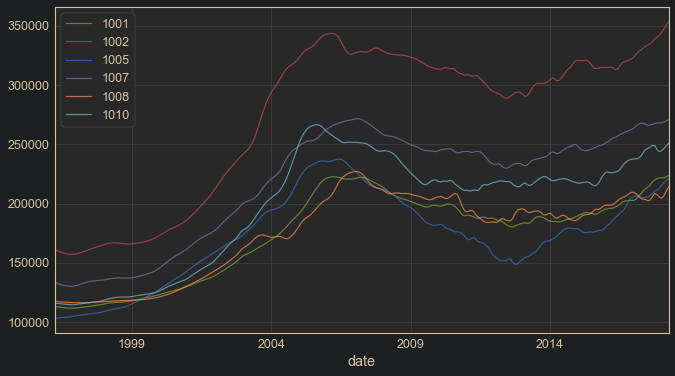

In [36]:
# A quick look at the first 6 zipcodes:
for i, (name, group) in enumerate(groups):
    print(name)
    group.set_index('date').value.plot(figsize=(11,6), alpha=0.7, label=name)
    if i >= 5:
        break
        
plt.legend();

Above we can start to see that not all zipcodes are growing at the same overall rate, and that the 2007 crisis had greater or more long lasting effects on certain ones. For instance, zipcode 01008 and 01001 both had less of a decline post-2007 than zipcode 01005, but they have all seemed to recover to around their pre-crash levels. Earlier, we saw that the average among all zip codes is higher than it was before the crash, meaning some zipcodes have been growing better than others since the low point around 2013, certainly better than the ones above, which all are pretty close to breaking even with their previous highs, though not quite for some of them.

### Checking Stationarity

In [37]:
from statsmodels.tsa.stattools import adfuller

Text(0.5, 1.0, 'Differenced medians across all zipcodes')

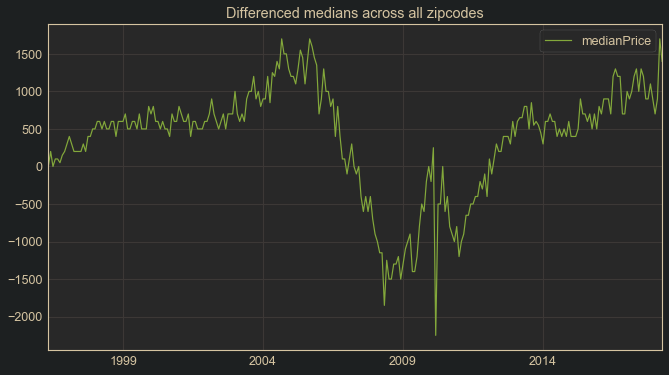

In [38]:
# I want to see what the total average market data would look like differenced
# This will give me an idea of how to transform each of the zipcodes when modeling them
# individually
# Also dropping the NaN created in differencing
medians_diff = medians.diff().dropna()
medians_diff.plot(figsize=(11,6))
plt.title("Differenced medians across all zipcodes")

In [39]:
# After differencing, we can still see the large trend caused by the crash and recovery of the
# market, indicating that the series is still not stationary.
# Also, we can see what may be yearly seasonality starting to appear

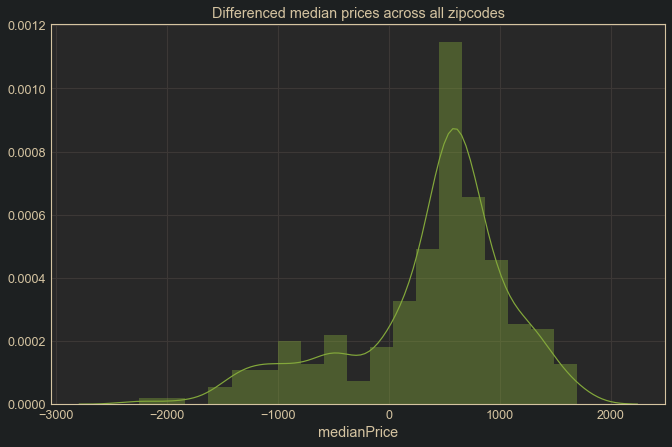

In [40]:
# We can see that these values are not quite normally distributed
import seaborn as sns
sns.distplot(medians_diff['medianPrice'])
plt.title("Differenced median prices across all zipcodes");

In [41]:
# Using Dickey-Fuller test on stationarity of differenced means
dftest = adfuller(medians_diff['medianPrice'])
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
print("Dickey-Fuller Results for Differenced Means:\n================================\n",dfoutput)

Dickey-Fuller Results for Differenced Means:
 Test Statistic                  -1.897610
p-value                          0.333186
#Lags Used                      12.000000
Number of Observations Used    251.000000
dtype: float64


In [42]:
# Above we can see that differencing the means has not made them stationary according to the
# Augmented Dickey-Fuller test, as the null hypothesis of non-stationarity has not been
# rejected. Let's see if further transformations or differencing will fix it

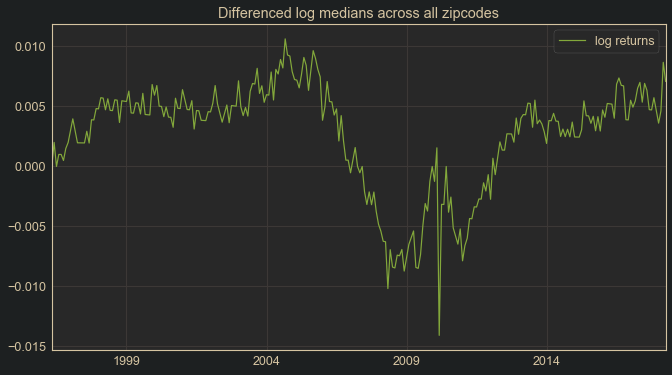

In [45]:
# Now to take the differenced log medians and compare
medians_diff_log = np.log(medians).diff().dropna()
medians_diff_log.plot(figsize=(11,6))
plt.legend(['log returns'])
plt.title("Differenced log medians across all zipcodes");

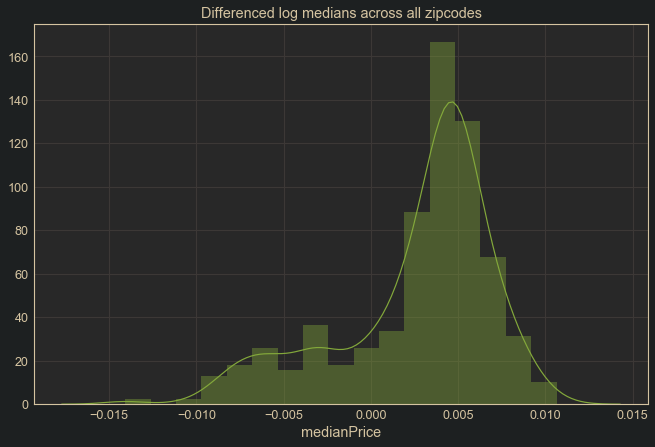

In [44]:
# And a look at the distribution:
sns.distplot(medians_diff_log['medianPrice'])
plt.title("Differenced log medians across all zipcodes");

In [96]:
dftest = adfuller(medians_diff_log['medianPrice'])
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
print("Dickey-Fuller Results for Differenced log medians:\n================================\n",dfoutput)

Dickey-Fuller Results for Differenced log medians:
 Test Statistic                  -1.496565
p-value                          0.535210
#Lags Used                       3.000000
Number of Observations Used    260.000000
dtype: float64


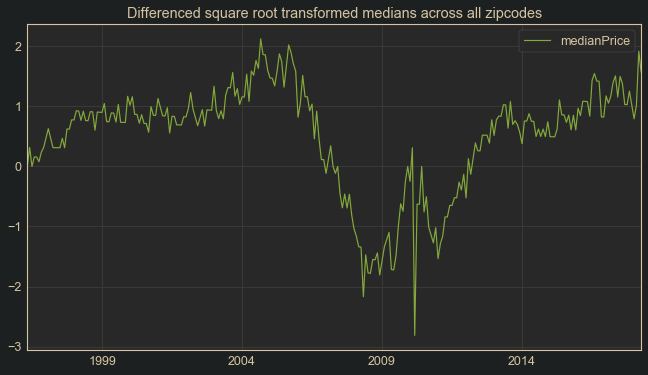

In [97]:
# It is clear this did not make the series more normal, and the Dickey-Fuller test did not 
# improve
# Now to try a square root transform:
medians_diff_sqrt = (medians ** (1/2)).diff().dropna()
medians_diff_sqrt.plot(figsize=(11,6))
plt.title("Differenced square root transformed medians across all zipcodes");

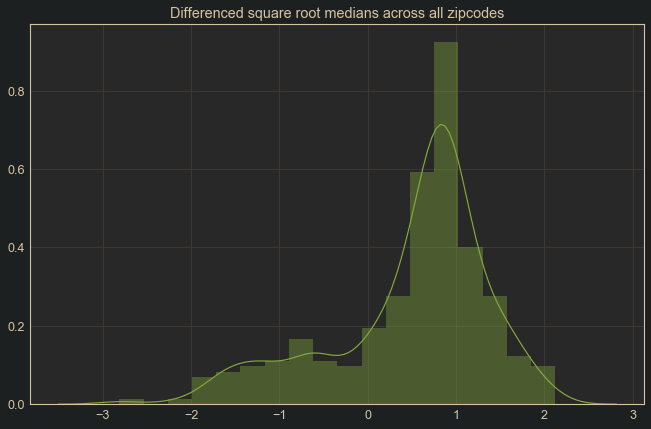

In [99]:
sns.distplot(medians_diff_sqrt)
plt.title("Differenced square root medians across all zipcodes");

In [100]:
dftest = adfuller(medians_diff_sqrt['medianPrice'])
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
print("Dickey-Fuller Results for Differenced square root transformed medians:\n================================\n",dfoutput)

Dickey-Fuller Results for Differenced square root transformed medians:
 Test Statistic                  -1.421717
p-value                          0.571821
#Lags Used                       3.000000
Number of Observations Used    260.000000
dtype: float64


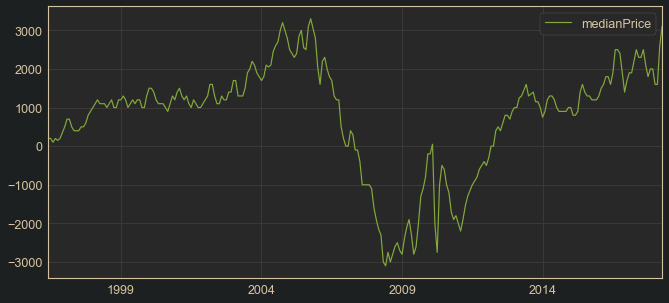

In [101]:
# Neither the log transform nor the square root transform has improved the stationarity
# Now to see how using a differencing period of 2 affects results
medians_diff2 = medians.diff(2).dropna()
medians_diff2.plot(figsize=(11,5))

In [102]:
# We can see the 2 period difference did not help much, but smoothed out some of the noise a bit

In [104]:
dftest = adfuller(medians_diff2['medianPrice'])
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
print("Dickey-Fuller Results for 2-period differenced medians:\n================================\n",dfoutput)

Dickey-Fuller Results for 2-period differenced medians:
 Test Statistic                  -1.940601
p-value                          0.313209
#Lags Used                      11.000000
Number of Observations Used    251.000000
dtype: float64


All of the above transformations did not provide a stationary time series. Upon further reading, I have realized that the d value in an ARIMA model represents recursive application of 1st degree differences. Below, I will see if two 1st order differences make for a stationary series:

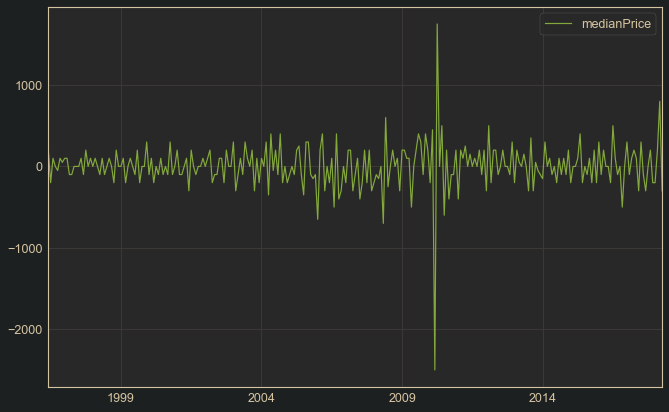

In [105]:
# Since the d value in ARIMA models does not represent the number of periods to difference
# across, but rather how many times a difference of 1 period is done recursively, I would like
# to see what a 2nd order differencing would do for the data:
medians_diff_2 = medians.diff().diff().dropna()
medians_diff_2.plot()

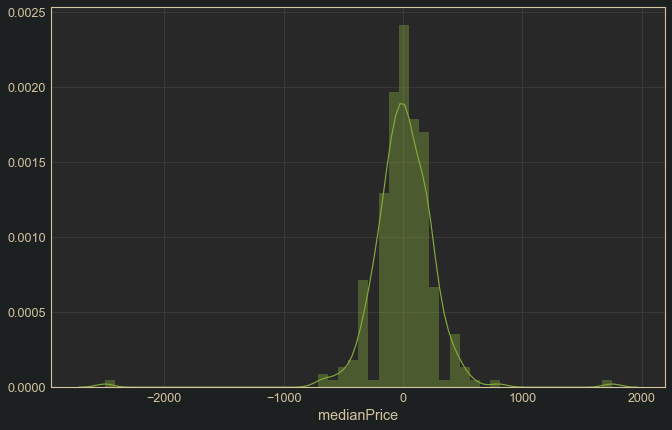

In [106]:
sns.distplot(medians_diff_2['medianPrice'])

In [107]:
dftest = adfuller(medians_diff_2['medianPrice'])
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
print("Dickey-Fuller Results for Differenced medians:\n================================\n",dfoutput)

Dickey-Fuller Results for Differenced medians:
 Test Statistic                -1.232974e+01
p-value                        6.467300e-23
#Lags Used                     2.000000e+00
Number of Observations Used    2.600000e+02
dtype: float64


In [ ]:
# We can see that this has made the time series stationary in regards to mean, but there is 
# visible heteroskedasticity. Let's see if a log transform would reduce that:
log_means_diff2 = np.log(medians).diff().diff().dropna()
log_means_diff2.plot()
plt.legend(['Differenced log returns'])
plt.xlabel('Date')
plt.ylabel('Differenced log returns')
plt.title('Differenced log returns of medians')

In [68]:
# This transformation did not tame the periods of high volatility. It is starting to look like
# the best option is to limit the time window to some time after the drama of the crash, but
# perhaps there is a way to filter or account for this heteroskedasticity.

It is worth noting at this point that the ADF test rejected the null hypothesis of non-stationarity, but this is misleading, because one of the requirements of a stationary time series is having constant variance across time. As cited in [Stockhammar & Oller (2007)](https://www.diva-portal.org/smash/get/diva2:187599/FULLTEXT01.pdf), a study by Kim and Schmidt (1993) showed that Dickey-Fuller tests tend to reject too often in the presence of conditional heteroscedasticity (pg. 4). In order for a time series to be considered weakly stationary, which is an assumption for ARIMA models, it must have constant mean AND variance. As Stockhammar and Oller go on to discuss in their paper, conditional heteroskedasticity can make it difficult to detect time-varying means, masking non-stationarity. This means that the non-stationarity in variance must be dealt with, or omitted from the data.

### Considering Returns Instead
Upon further reading on modeling financial markets, it has come to my attention that people generally model returns rather than the prices, because these tend to more closely resemble normal distributions, and have better stationarity. Further, returns are generally calculated in practice as log returns, due to their additive properties. When returns are represented as percentages, they are multiplicative of their previous value, whereas log returns can be added together rather than multiplied. This make for more convenient math considering sequential data, since a cumsum() method can combine all of the growth.

In [109]:
# Creating log returns and checking
log_returns = np.log(medians).diff().dropna()
log_returns.columns = ['returns']
log_returns.head()

,returns
1996-05-01,0.000000
1996-06-01,0.002008
1996-07-01,0.000000
1996-08-01,0.001003
1996-09-01,0.001002


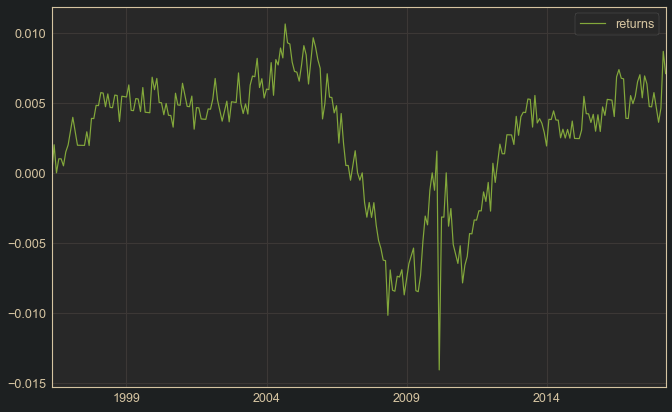

In [110]:
# A look at the plot
log_returns.plot()

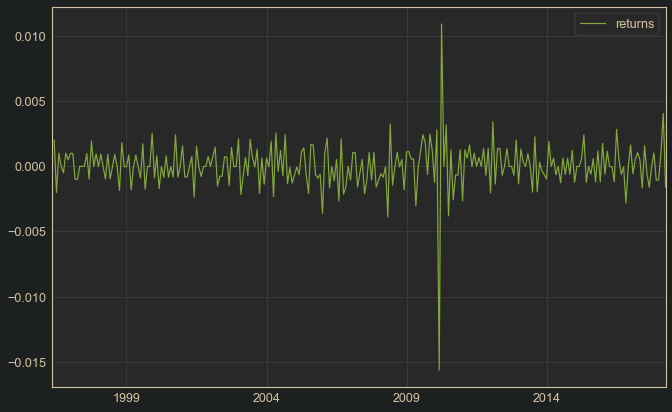

In [111]:
# We can see that this is the same as the step taken earlier, but for a different reason.
# Before, I was counting on the log transformation to make the data more normal and stationary,
# but this time I have done it to represent the returns over the course of the series.
# Since we determined before that 2nd order differencing made the most stationary results,
# and the returns incorporate one order of differencing already, these returns just need to
# be differenced one more time to become more stationary
log_returns.diff().plot()

### Looking at Seasonal Decomposition

I'd like to see what the seasonal_decompose function does with this data.

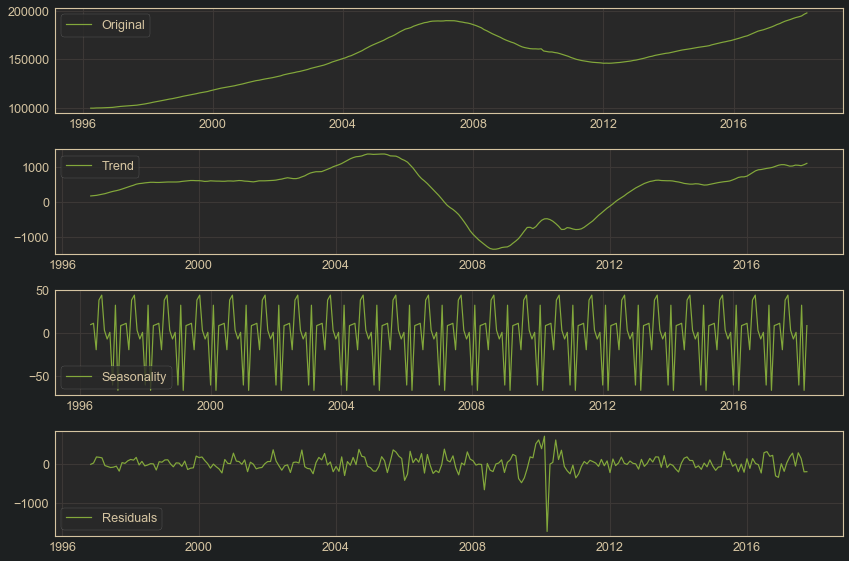

In [112]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(medians_diff)

# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(medians.dropna(), label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [113]:
# We can see that when the decomposition removes the large sweeping trend
# This decomposition seems to be detecting yearly seasonality as well
# The residuals show heteroscedasticity, with the spikes in the familiar places.

### Using Periodogram to find long-term seasonality

I would now like to see if a periodogram can detect some longer seasonal trends

In [114]:
from scipy.signal import periodogram

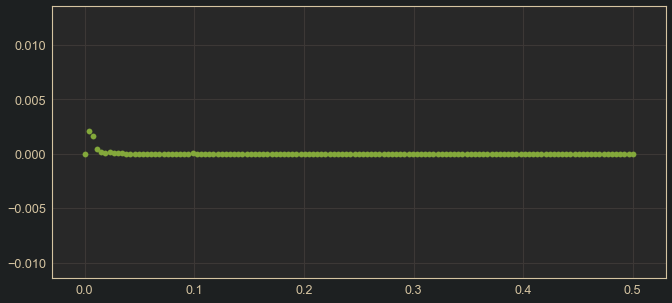

In [115]:
pgram = periodogram(log_returns['returns'])
plt.figure(figsize=(11,5))
plt.scatter(pgram[0], pgram[1]);

In [116]:
# Finding 3 largest specs:
indices = np.argpartition(pgram[1], -3)[-3:]
pd.DataFrame(list(zip((1 / pgram[0][indices])[::-1], pgram[1][indices][::-1])),
             columns=['Period', 'Spec']
            )

,Period,Spec
0,264.0,0.002114
1,132.0,0.001668
2,88.0,0.000451


We can see that the most influential periods from the periodogram are periods which correspond to the full length of the dataset, half the length of the dataset, and a third of the length of the dataset. As shown in the investigation in [this notebook](understanding_fourier_series_with_R.ipynb), this is merely an artifact of the math involved in the periodogram, and does not give us conclusive evidence of a long term seasonality. As was shown in the other notebook, a mostly random set of data will show spikes on a periodogram at the full length of the data, and another at the halfway point. It should be noted however that the strength of the spike at the half-period in this series is stronger than expected for random data.

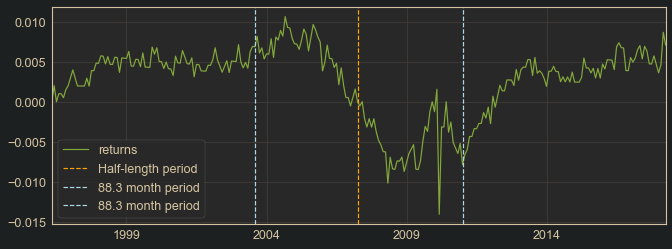

In [118]:
# Here we can observe visually the periods indicated by the periodogram, and see that there is
# no real seasonality at these periods:
ax = log_returns.plot(figsize=(11,4))
ax.axvline(medians.index[132], 
           color='orange', 
           ls='--',
           label='Half-length period'
          )
ax.axvline(medians.index[88], 
           color='lightblue', 
           ls='--',
           label='88.3 month period'
          )
ax.axvline(medians.index[177], 
           color='lightblue', 
           ls='--',
           label='88.3 month period'
          )
plt.legend();

To drive this point home, the reason that a powerful spike will always be present at the period corresponding to the full length of a dataset is because you can take any time series of data, and lay it end on end some number of times, and produce a seasonality. This is shown below.

In [94]:
# Placing the trend data end on end
trend2 = pd.concat([pd.DataFrame(log_returns), 
                    pd.DataFrame(log_returns)], axis=0).reset_index()

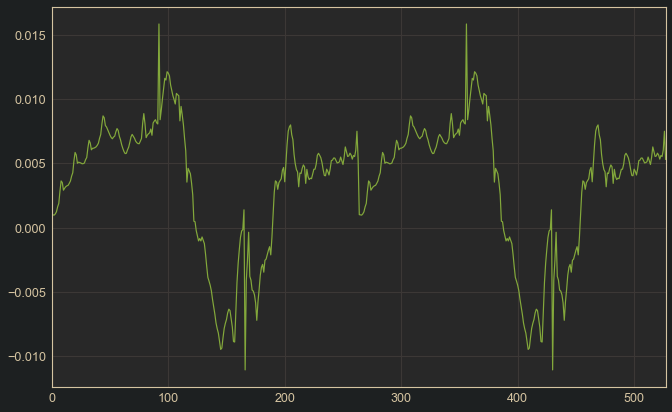

In [96]:
# Here we can see that having a seasonality the full length of data is not a valid assumption
# since repeating data is bound to make seasonality occur
trend2.returns.plot();

### Looking at autocorrelation

In [97]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

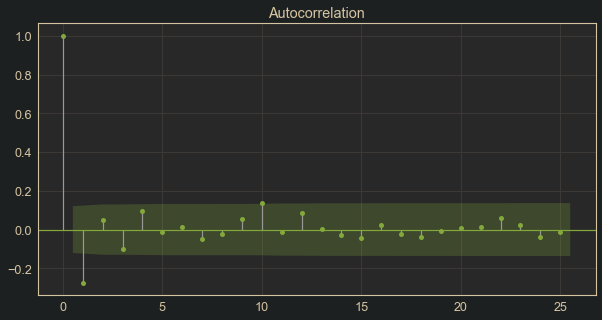

In [104]:
# First a look at an ACF for the stationary series produced by 2nd order differencing
# Note that a sharp dropoff past a certain value would inform us of a potential order for 
# MA terms
fig, ax = plt.subplots(figsize=(10,5))
plot_acf(log_returns.diff().dropna(), 
          #lags = len(trend.dropna())-1, 
          ax=ax);

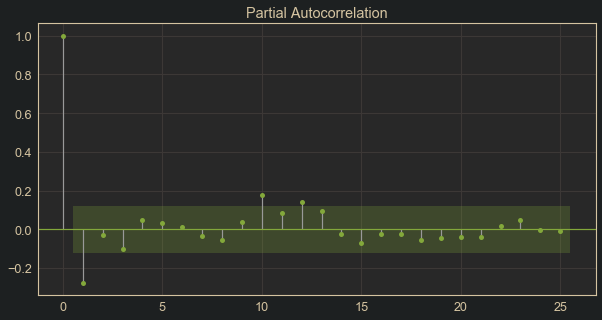

In [105]:
# We can see above that the ACF drops off after 1 lag, meaning an MA(1) model may be appropriate
# Now a look at a PACF for the series. Note that a sharp dropoff after a lag will indicate a
# potential order for AR terms, and a taper past a lag would be further evidence for an order
# of MA terms
fig, ax = plt.subplots(figsize=(10,5))
plot_pacf(log_returns.diff().dropna(), 
          #lags = len(trend.dropna())-1, 
          ax=ax);

In [75]:
# Above we can see that a similar dropoff occurs on both the ACF and PACF, meaning some model
# comparisons will be necessary to figure out the proper order for AR and MA

## Modeling:

### Facebook Prophet on full data:
Before going into fitting SARIMAX models on the data, I want to see what kind of predictions fbprophet will make, just as a comparison/benchmark, since prophet's predictions are generally considered to be reliable.

In [106]:
# I am going to do a fbprophet forecast on the mean market data, to see how it behaves
from fbprophet import Prophet as proph

In [107]:
means_proph = means.copy()
means_proph.head()

,mean price
1996-04-01,118299.123063
1996-05-01,118419.044139
1996-06-01,118537.423268
1996-07-01,118653.069278
1996-08-01,118780.254312


In [108]:
# Need to format the new dataframe for prophet
means_proph['ds'] = means_proph.index
means_proph['ds'] = means_proph['ds'].asfreq('MS')
means_proph.rename(columns={'mean price':'y'}, inplace=True)
means_proph.head()

,y,ds
1996-04-01,118299.123063,1996-04-01
1996-05-01,118419.044139,1996-05-01
1996-06-01,118537.423268,1996-06-01
1996-07-01,118653.069278,1996-07-01
1996-08-01,118780.254312,1996-08-01


In [109]:
Model = proph(interval_width=0.95)
Model.fit(means_proph)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [110]:
# I will make projections 5yrs into the future, as this seems to be a good time horizon for
# real estate investment.
future_dates = Model.make_future_dataframe(periods=60, freq='MS')
predictions = Model.predict(future_dates)
pred_subset = predictions[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

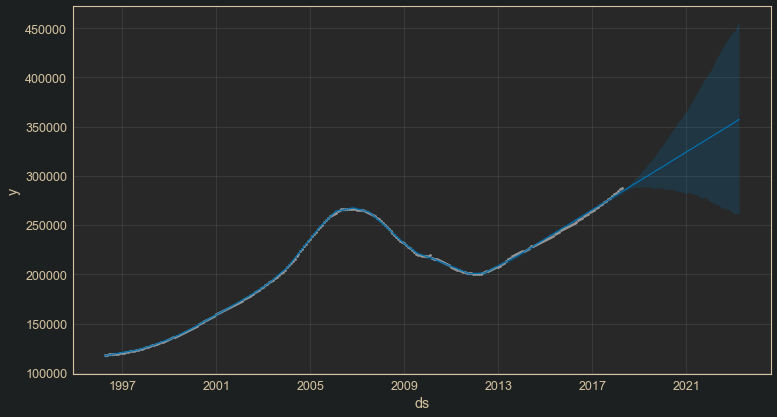

In [111]:
fig, ax = plt.subplots(figsize=(11, 6))
Model.plot(predictions, uncertainty=True, ax=ax);

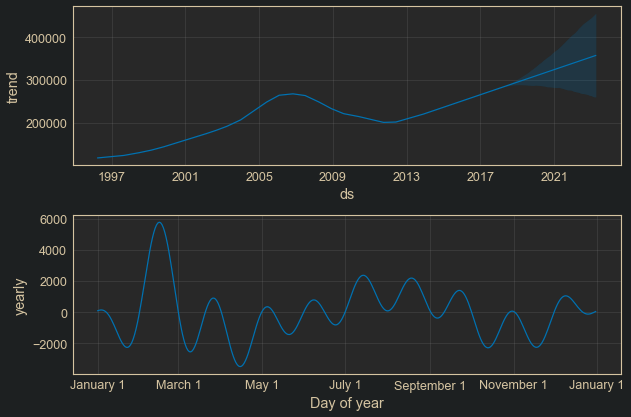

In [112]:
#fig, ax = plt.subplots(figsize=(11, 6))
ax = Model.plot_components(predictions)
ax.set_facecolor(plt.rcParams.get('figure.facecolor'))

We can see that Prophet has done its under-the-hood magic, and produced forecasts that are essentially a linear continuation of the trend after the market crash, with a confidence window that incorporates a possible second crash around the years 2020-2021. This is a pretty good result, considering that it was fast and seems to cover the different scenarios of the future market. It will be interesting to see how this stacks up to an ARIMA model on the same data (knowing that the data will be heteroscedastic, these models will still perform decently).

### Facebook Prophet on Returns:

In [113]:
returns_proph = log_returns.copy()
returns_proph.head()

,returns
1996-05-01,0.001013
1996-06-01,0.000999
1996-07-01,0.000975
1996-08-01,0.001071
1996-09-01,0.001239


In [116]:
# Need to format the new dataframe for prophet
returns_proph['ds'] = returns_proph.index
returns_proph['ds'] = returns_proph['ds'].asfreq('MS')
returns_proph.rename(columns={'returns':'y'}, inplace=True)
returns_proph.head()

,y,ds
1996-05-01,0.001013,1996-05-01
1996-06-01,0.000999,1996-06-01
1996-07-01,0.000975,1996-07-01
1996-08-01,0.001071,1996-08-01
1996-09-01,0.001239,1996-09-01


In [117]:
Model = proph(interval_width=0.95)
Model.fit(returns_proph)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [118]:
# I will make projections 5yrs into the future, as this seems to be a good time horizon for
# real estate investment.
future_dates = Model.make_future_dataframe(periods=60, freq='MS')
predictions = Model.predict(future_dates)
pred_subset = predictions[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

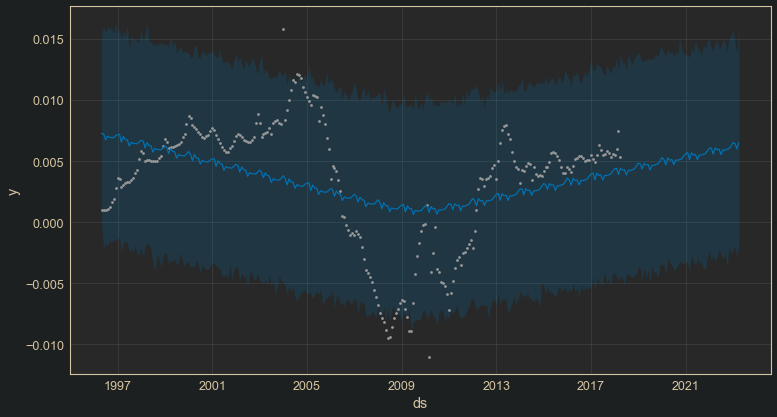

In [119]:
fig, ax = plt.subplots(figsize=(11, 6))
Model.plot(predictions, uncertainty=True, ax=ax);

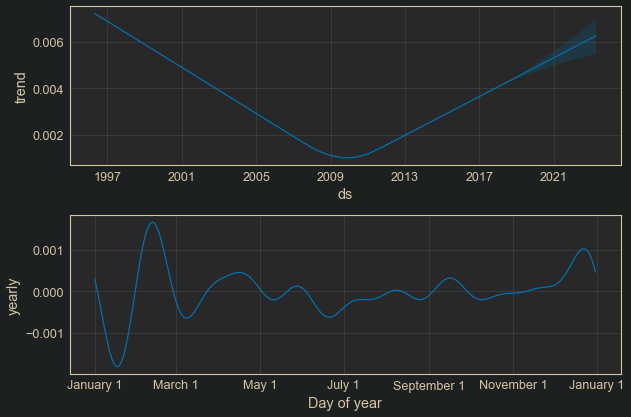

In [120]:
#fig, ax = plt.subplots(figsize=(11, 6))
ax = Model.plot_components(predictions)
ax.set_facecolor(plt.rcParams.get('figure.facecolor'))

Facebook prophet seems to have exhibited some strange behavior on the log returns... But it does seem to have also indicated some yearly seasonality.

### ARIMA on full data:

I'm now going to fit an ARIMA model to the means data, just to compare to facebook prophet, knowing that there is a special event taking place with the crash, and that the conditional heteroscedasticity violates the stationarity assumption.

In [121]:
import itertools
import statsmodels.api as sm

In [122]:
# Checking to see if index has an assigned frequency
means.index

DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', length=265, freq=None)

In [123]:
# Need to fix the dataframe to have an explicit frequency for statsmodels
means_fix = means.asfreq('MS')
means_fix.index

DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', length=265, freq='MS')

In [124]:
# Quick check for NaN values
means_fix.isna().sum()

mean price    0
dtype: int64

In [19]:
# Let's start with letting the max p, d, and q be 2
p = d = q = range(0, 3)

# Generating all combos of p, d, and q
pdq = list(itertools.product(p, d, q))

# Since we saw potential quarterly seasonality earlier, I will use a s value of 3, and make 
# necessary combinations:
pdqs = [(x[0], x[1], x[2], 12) for x in pdq]

NameError: name 'itertools' is not defined

In [126]:
# checking pdq
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (1, 0, 0),
 (1, 0, 1),
 (1, 0, 2),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 2, 0),
 (1, 2, 1),
 (1, 2, 2),
 (2, 0, 0),
 (2, 0, 1),
 (2, 0, 2),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 2, 0),
 (2, 2, 1),
 (2, 2, 2)]

In [127]:
# checking pdqs
pdqs

[(0, 0, 0, 3),
 (0, 0, 1, 3),
 (0, 0, 2, 3),
 (0, 1, 0, 3),
 (0, 1, 1, 3),
 (0, 1, 2, 3),
 (0, 2, 0, 3),
 (0, 2, 1, 3),
 (0, 2, 2, 3),
 (1, 0, 0, 3),
 (1, 0, 1, 3),
 (1, 0, 2, 3),
 (1, 1, 0, 3),
 (1, 1, 1, 3),
 (1, 1, 2, 3),
 (1, 2, 0, 3),
 (1, 2, 1, 3),
 (1, 2, 2, 3),
 (2, 0, 0, 3),
 (2, 0, 1, 3),
 (2, 0, 2, 3),
 (2, 1, 0, 3),
 (2, 1, 1, 3),
 (2, 1, 2, 3),
 (2, 2, 0, 3),
 (2, 2, 1, 3),
 (2, 2, 2, 3)]

In [128]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [129]:
len(pdq)*len(pdqs)

729

In [130]:
combos = np.zeros(len(pdq)*len(pdqs))
aic_values = np.zeros(len(pdq)*len(pdqs))
scores = {}

for combo in pdq:
    for scombo in pdqs:
        model_params = (combo, scombo)
        scores[model_params] = np.NaN
        try:
            sarimax = SARIMAX(means_fix,
                              order=combo,
                              seasonal_order=scombo,
                              enforce_stationarity=False,
                              enforce_invertibility=False
                             )
            output = sarimax.fit()
            scores[model_params] = output.aic
            
        except:
            print("Error with parameters:", model_params)
            continue

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check

In [131]:
len(scores)

729

In [132]:
# Noting that this is taking a long time, whereas the auto.arima() function in R is very fast,
# it will be interesting to compare the results, after the wait. Note that the result from the
# R notebook was (0, 2, 1) with no seasonality, resulting in an AIC of 3705.08

# Another note is that this is taking a REALLY long time, so that it would not be possible to 
# generate a model in this way for each individual zipcode. It may be necessary to find the
# optimal pdq values generated by a model on the means, then apply those parameters to each
# zipcode, or it might be fast enough to use the auto.arima() function in R for each zipcode,
# allowing for more flexibility with the different data in each zipcode.

In [133]:
# Find the parameters with minimal AIC value
ideal_params = min(scores, key=scores.get)
print("Optimal AIC of {} with params: {}".format(min(scores.values()), ideal_params))
#print(ideal_params)

Optimal AIC of 3561.377285683977 with params: ((0, 2, 2), (0, 1, 2, 3))


In [134]:
model = SARIMAX(means_fix,
                order=ideal_params[0],
                seasonal_order=ideal_params[1],
                enforce_stationary=False,
                enforce_invertibility=False
               ).fit()
print(model.summary())

                                 Statespace Model Results                                
Dep. Variable:                        mean price   No. Observations:                  265
Model:             SARIMAX(0, 2, 2)x(0, 1, 2, 3)   Log Likelihood               -1929.486
Date:                           Tue, 11 Aug 2020   AIC                           3868.972
Time:                                   18:30:30   BIC                           3886.775
Sample:                               04-01-1996   HQIC                          3876.129
                                    - 04-01-2018                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0562      0.013     -4.422      0.000      -0.081      -0.031
ma.L2          0.0080      0.027      0.294

In [135]:
# For some reason, the AIC of this model does not match the score from the grid search...
# I have reviewed the code and have no explanation for this.
# I will build a nested for loop and see if this gets rid of the bug
scores = {}
rang = range(0,3)

for p in rang:
    for d in rang:
        for q in rang:
            for sp in rang:
                for sd in rang:
                    for sq in rang:
                        model_params = ((p,d,q), (sp,sd,sq,3))
                        scores[model_params] = np.NaN
                        try:
                            sarimax = SARIMAX(means_fix,
                                              order=(p,d,q),
                                              seasonal_order=(sp,sd,sq,3),
                                              enforce_stationarity=False,
                                              enforce_invertibility=False
                                             )
                            output = sarimax.fit()
                            scores[model_params] = output.aic

                        except:
                            print("Error with parameters:", model_params)
                            continue

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check

In [137]:
# Find the parameters with minimal AIC value
ideal_params2= min(scores, key=scores.get)
print("Optimal AIC of {} with params: {}".format(min(scores.values()), ideal_params2))
#print(ideal_params)

Optimal AIC of 3561.377285683977 with params: ((0, 2, 2), (0, 1, 2, 3))


In [ ]:
# Again, the grid search has produced an AIC value that is different from what I get when I run
# the model with the same parameters

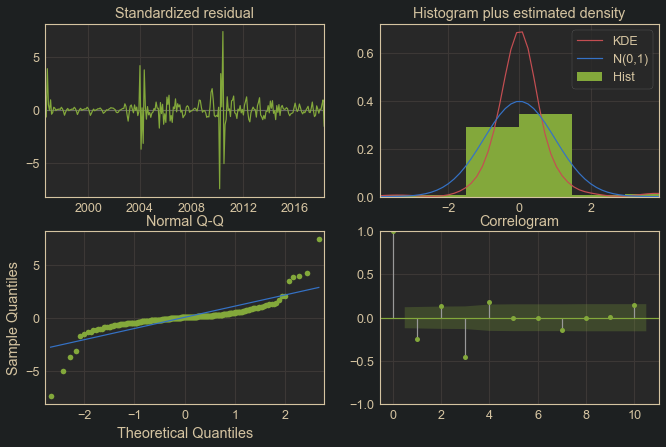

In [299]:
model.plot_diagnostics(figsize=(11,7));

In [ ]:
# Diagnosing the model, we can see that the null hypothesis of the Ljung-Box test that the
# residuals are not autocorrelated is firmly rejected, which is not good.
# We can also see that the null hypothesis of the Heteroskedasticity test, which is that the
# residuals are not heteroskedastic, is not rejected, though it can be seen in the plot
# The kurtosis is quite high and thus the JB test null hypothesis of normal skew and kurtosis
# of residuals is rejected.

In [302]:
# Modeling again, removing the non-significant parameters
model = SARIMAX(means_fix,
                order=(0,2,1),
                seasonal_order=(0,1,1,3),
                enforce_stationary=False,
                enforce_invertibility=False
               ).fit()
print(model.summary())

                                 Statespace Model Results                                
Dep. Variable:                        mean price   No. Observations:                  265
Model:             SARIMAX(0, 2, 1)x(0, 1, 1, 3)   Log Likelihood               -1930.941
Date:                           Tue, 04 Aug 2020   AIC                           3867.882
Time:                                   19:54:40   BIC                           3878.564
Sample:                               04-01-1996   HQIC                          3872.177
                                    - 04-01-2018                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0493      0.014     -3.588      0.000      -0.076      -0.022
ma.S.L3       -0.1017      0.008    -12.019

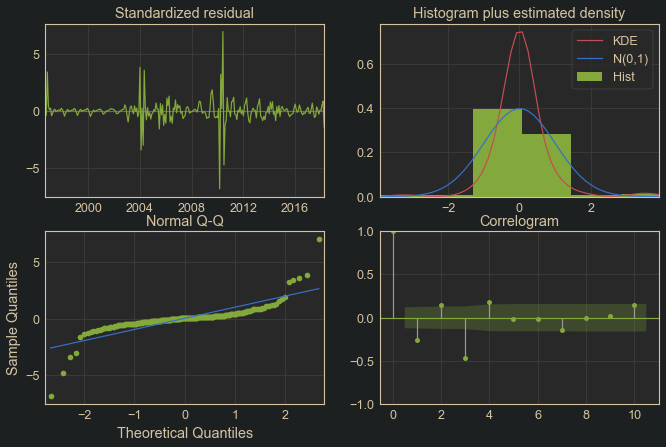

In [303]:
model.plot_diagnostics(figsize=(11,7));

In [115]:
# The null hypothesis of the Ljung-Box test of non-autocorrelated residuals is rejected
# The null hypothesis of the Heteroskedasticity test of homoskedastic residuals is 
# not rejected
# The JB null hypothesis of normal skew and kurtosis is rejected

In [120]:
pd.plotting.register_matplotlib_converters()

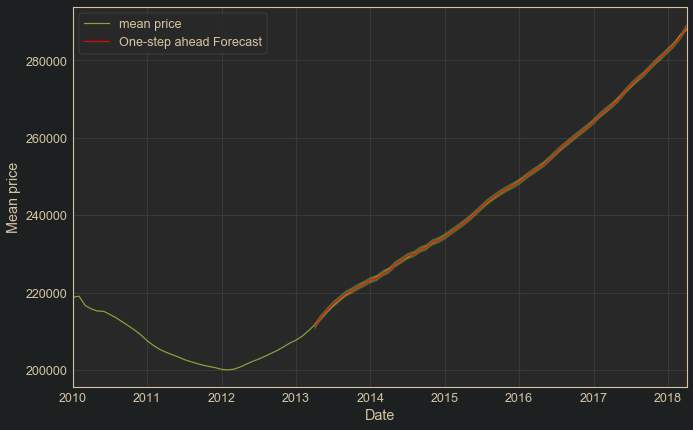

In [304]:
# Get predictions
pred = model.get_prediction('2013-04', '2018-04', dynamic=False)
pred_conf = pred.conf_int()
# Plot observed values
ax = means['2010':].plot(label='observed')
# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', color='red', alpha=0.9)
# Plot the range for confidence intervals
ax.fill_between(pred_conf.index, 
                pred_conf.iloc[:, 0], 
                pred_conf.iloc[:, 1],
                alpha=0.5
               )
# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Mean price')
plt.legend()
plt.show()

In [305]:
forecasted = pred.predicted_mean
truth = means_fix['2013-04':'2018-04']['mean price']

# Compute the mean square error
mse = np.mean((forecasted - truth) ** 2)
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 35592.7


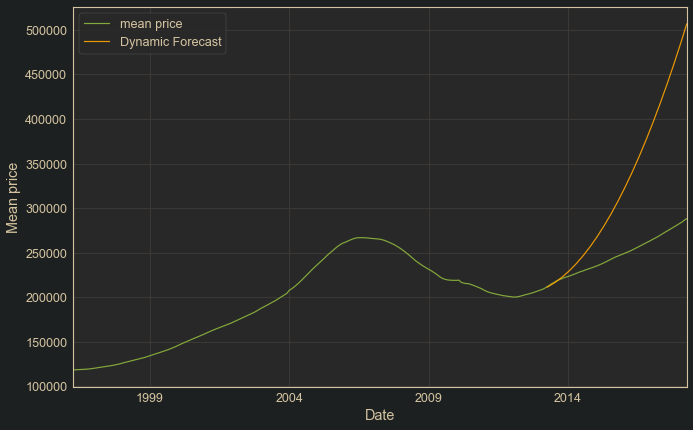

In [306]:
# We can see that the one step ahead forecasts were fairly accurate on the training data,
# let's look now at the dynamic forecast from the same date

# Get dynamic predictions with confidence intervals
pred_dynamic = model.get_prediction(start='2013-04', end='2018-04', dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

# Plot observed values
ax = means_fix.plot(label='observed')
# Plot predicted values
pred_dynamic.predicted_mean.plot(ax=ax, label='Dynamic Forecast', color='orange', alpha=0.9)
# Plot the range for confidence intervals
#ax.fill_between(pred_dynamic_conf.index, 
#                pred_dynamic_conf.iloc[:, 0], 
#                pred_dynamic_conf.iloc[:, 1],
#                alpha=0.5
#               )
#ax.fill_betweenx(ax.get_ylim(), 
#                 pd.to_datetime('2013-04'), 
#                pred_dynamic.predicted_mean.index[-1],
#                alpha=0.1,
#                zorder=-1
#               )
# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Mean price')
plt.legend()
plt.show()

In [307]:
# We can see that this has not gone well, the forecast is way off of the observed line
# Moving the cutoff point further into the dataset mitigates this, but there is still a lot of
# error.

In [308]:
# Despite the shortcomings of this model, let's see what a 5 year future forecast looks like
# with it
prediction = model.get_forecast(60)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

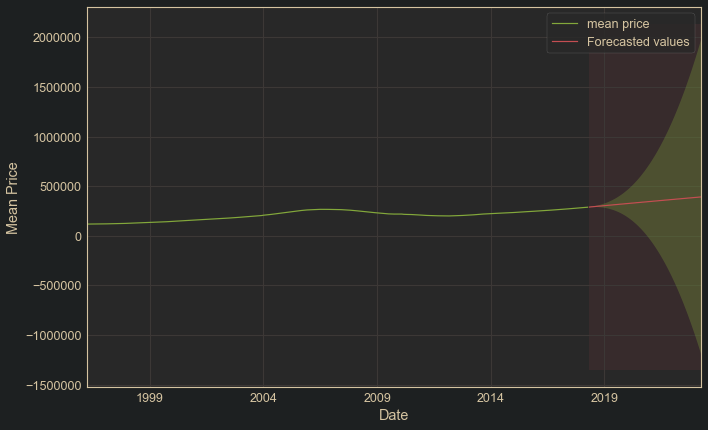

In [309]:
# Plot future predictions with confidence intervals
ax = means_fix.plot(label='observed')
prediction.predicted_mean.plot(label='Forecasted values', ax=ax)

ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1],
                alpha=0.3
               )

ax.fill_betweenx(ax.get_ylim(), pred_conf.index[0], pred_conf.index[-1],
                 alpha=0.1,
                 zorder=-1
                )

ax.set_xlabel('Date')
ax.set_ylabel('Mean Price')
plt.legend()
plt.show()

In [138]:
# Again, the results are terrible.
# I want to try a much simpler model, like the one that the auto.arima() function in R
# recommended, to see how it compares.
model = SARIMAX(means_fix,
                order=(0,2,1),
                #seasonal_order=(0,2,3,4),
                enforce_stationary=False,
                enforce_invertibility=False
               ).fit()
print(model.summary())

                           Statespace Model Results                           
Dep. Variable:             mean price   No. Observations:                  265
Model:               SARIMAX(0, 2, 1)   Log Likelihood               -1857.963
Date:                Tue, 11 Aug 2020   AIC                           3719.926
Time:                        18:43:01   BIC                           3727.071
Sample:                    04-01-1996   HQIC                          3722.798
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0666      0.014     -4.919      0.000      -0.093      -0.040
sigma2      7.702e+04   1565.269     49.203      0.000    7.39e+04    8.01e+04
Ljung-Box (Q):                       34.52   Jarque-

In [139]:
# We can see that this model has a better AIC and log likelihood. Somehow something must have
# gone wrong with the grid search above, because the AIC for the model with the parameters
# that process recommended did not have as good of an AIC as what was printed out with the 
# parameters. Perhaps (0,0,0,4) for a seasonal order is not equivalent to leaving out the
# seasonal component...
# This time, the Ljung-Box test is showing that the residuals are not autocorrelated,
# but there is still a problem with heteroskedasticity. Also, the JB score is quite high due
# to the large amount of kurtosis due to the extreme values in the residuals.

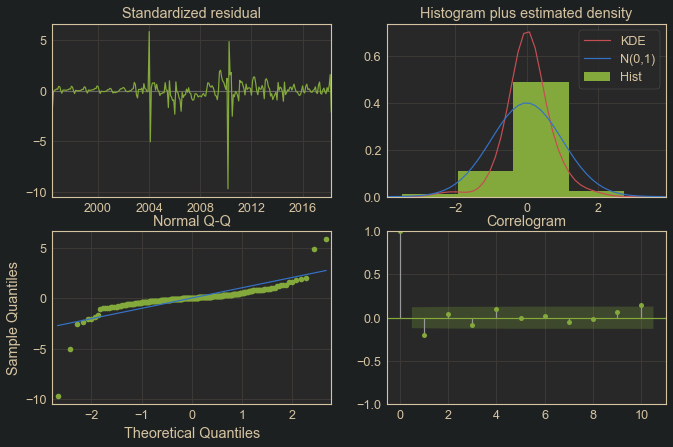

In [140]:
# A look at the diagnostics for this much simpler model:
model.plot_diagnostics(figsize=(11,7));

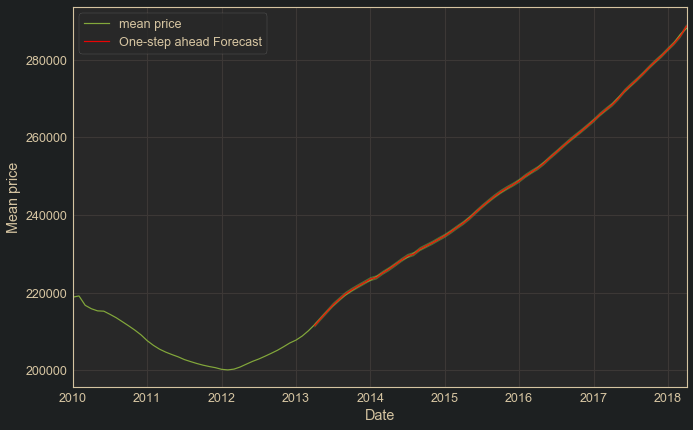

In [313]:
# Let's see the predictive behavior of this simple model in
# comparison.
# Get predictions
pred = model.get_prediction('2013-04', '2018-04', dynamic=False)
pred_conf = pred.conf_int()
# Plot observed values
ax = means_fix['2010':].plot(label='observed')
# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', color='red', alpha=0.9)
# Plot the range for confidence intervals
ax.fill_between(pred_conf.index, 
                pred_conf.iloc[:, 0], 
                pred_conf.iloc[:, 1],
                alpha=0.5
               )
# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Mean price')
plt.legend()
plt.show()

In [314]:
forecasted = pred.predicted_mean
truth = means_fix['2013-04':'2018-04']['mean price']

# Compute the mean square error
mse = np.mean((forecasted - truth) ** 2)
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 22405.72


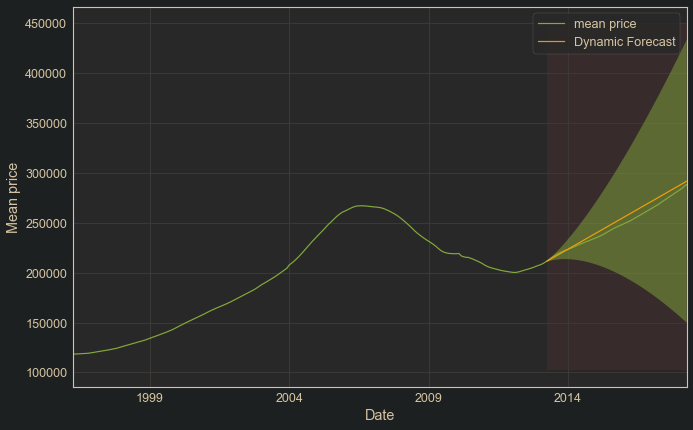

In [315]:
# We can see the simple model is far outperforming the more complex one with seasonality.
# The confidence interval is not even observable on the graph, and the MSE is far lower.
# Let's look now at the dynamic forecasting, with the same 5 year cutoff to most recent data
# Get dynamic predictions with confidence intervals
pred_dynamic = model.get_prediction(start='2013-04', end='2018-04', dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

# Plot observed values
ax = means_fix.plot(label='observed')
# Plot predicted values
pred_dynamic.predicted_mean.plot(ax=ax, label='Dynamic Forecast', color='orange', alpha=0.9)
# Plot the range for confidence intervals
ax.fill_between(pred_dynamic_conf.index, 
                pred_dynamic_conf.iloc[:, 0], 
                pred_dynamic_conf.iloc[:, 1],
                alpha=0.5
               )
ax.fill_betweenx(ax.get_ylim(), 
                 pd.to_datetime('2013-04'), 
                pred_dynamic.predicted_mean.index[-1],
                alpha=0.1,
                zorder=-1
               )
# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Mean price')
plt.legend()
plt.show()

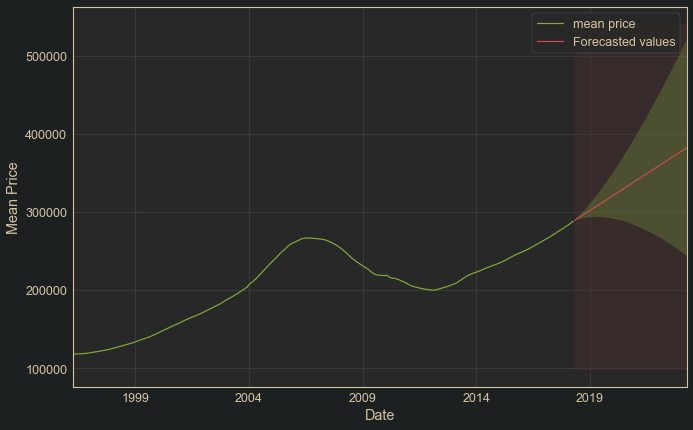

In [316]:
# As we can see, the mean prediction line is fairly spot on, but the confidence interval is 
# very wide, meaning that there would be low confidence for the investor had they not known
# the actual data.
# Let's see now how the 5 year projection looks
prediction = model.get_forecast(60)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()
# Plot future predictions with confidence intervals
ax = means_fix.plot(label='observed')
prediction.predicted_mean.plot(label='Forecasted values', ax=ax)

ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1],
                alpha=0.3
               )

ax.fill_betweenx(ax.get_ylim(), pred_conf.index[0], pred_conf.index[-1],
                 alpha=0.1,
                 zorder=-1
                )

ax.set_xlabel('Date')
ax.set_ylabel('Mean Price')
plt.legend()
plt.show()

In [78]:
# This looks to be the same result returned from the auto.arima() function in R
# This is not bad, but again the confidence intervals are very wide.

# These results are also similar to those from the fbprophet model, except that the confidence
# bands are wider.

# The diagnostics for this model were fairly good, but we can see from the Q-Q plot of residuals
# that the distribution of residuals has very thin tails. This is due to the periods of
# high volatility around the time of the crash.

In [336]:
# I would now like to do another grid search, this time leaving out the seasonal component
# altogether, to see if python reaches the same result as auto.arima() in this way
scores = {}
for combo in pdq:
    scores[combo] = np.NaN
    sarimax = SARIMAX(means_fix,
                      order=combo,
                      enforce_stationarity=False,
                      enforce_invertibility=False
                     )
    output = sarimax.fit()
    scores[combo] = output.aic

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [337]:
# Find the parameters with minimal AIC value
ideal_params = min(scores, key=scores.get)
print("Optimal AIC of {} with params: {}".format(min(scores.values()), ideal_params))

Optimal AIC of 3667.539565439485 with params: (0, 2, 2)


In [338]:
scores

{(0, 0, 0): 7227.7079129085505,
 (0, 0, 1): 7010.00513809116,
 (0, 0, 2): 6941.573909104385,
 (0, 1, 0): 4522.908195768892,
 (0, 1, 1): 4245.393933165031,
 (0, 1, 2): 4046.795195240322,
 (0, 2, 0): 3709.270568279877,
 (0, 2, 1): 3678.88147914604,
 (0, 2, 2): 3667.539565439485,
 (1, 0, 0): 4475.332919259364,
 (1, 0, 1): 4294.657407073918,
 (1, 0, 2): 4227.693137501441,
 (1, 1, 0): 3721.9022826125192,
 (1, 1, 1): 3693.4678569050784,
 (1, 1, 2): 3681.662481206379,
 (1, 2, 0): 3691.576156191074,
 (1, 2, 1): 3680.438607484998,
 (1, 2, 2): 3668.533715036324,
 (2, 0, 0): 3723.225527949846,
 (2, 0, 1): 3721.67379972293,
 (2, 0, 2): 3698.0347892593973,
 (2, 1, 0): 3692.467177822459,
 (2, 1, 1): 3694.4747650796457,
 (2, 1, 2): 3682.924827113188,
 (2, 2, 0): 3680.4635575126426,
 (2, 2, 1): 3682.5067440537396,
 (2, 2, 2): 3669.852647055137}

In [341]:
# This does seem to produce a lower AIC score, let's see this model
model = SARIMAX(means_fix,
                order=(0,2,2),
                enforce_stationary=False,
                enforce_invertibility=False
               ).fit()
print(model.summary())

                           Statespace Model Results                           
Dep. Variable:             mean price   No. Observations:                  265
Model:               SARIMAX(0, 2, 2)   Log Likelihood               -1857.932
Date:                Tue, 04 Aug 2020   AIC                           3721.863
Time:                        22:26:26   BIC                           3732.579
Sample:                    04-01-1996   HQIC                          3726.170
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0647      0.015     -4.273      0.000      -0.094      -0.035
ma.L2          0.0054      0.052      0.103      0.918      -0.097       0.108
sigma2      7.815e+04   1635.899     47.771      0.0

In [335]:
model.aic

7064.474101625354

In [144]:
# Interestingly enough, the grid search has yet again deceived me in the AIC that the model
# parameters produce. This method has simply not paid off so far, instead of troubleshooting
# this inefficient method, I will just stick to using the auto.arima() function in R, since
# it is faster and more reliable.

Before I move on to any more modeling, it has come to my attention that the auto.arima() model from R is faster than grid searching for (p, d, q) values in python. It would be ideal to be able to call these functions from python, and apparently there is a way to do that using a package called rpy2. I will now try and get that to work.

The first function in R that I'd like to get to use through python is the fourier() function from the 'forecast' package. It generates a Fourier series for the input data, which can be used as exogenous terms in an ARIMA function.

In [141]:
# Allows you to import r packages
from rpy2.robjects.packages import importr

In [84]:
# How to install r packages from python
#utils = importr('utils')
#utils.install_packages('forecast')

rpy2.rinterface.NULL

In [142]:
# Import desired package(s)
importr('forecast')

rpy2.robjects.packages.Package as a <module 'forecast'>

In [143]:
# Will convert python lists to a R style FloatVector
from rpy2.robjects import FloatVector

In [144]:
from collections import OrderedDict
from rpy2.robjects import DataFrame

In [145]:
rlist = list(map(FloatVector, [means_fix['mean price']]))

In [146]:
d = OrderedDict(zip(map(str, range(len(rlist))), rlist))
data = DataFrame(d)

In [147]:
# Convert series into a usable format
FloatVector(means_fix['mean price'])

118299.123063,118419.044139,118537.423268,118653.069278,...,282657.060382,284368.688447,286511.376757,288039.944305


In [148]:
from rpy2.robjects import r

First, a bit of a detour into generating Fourier Series from R using python. Note that this ultimately does not come in handy for this project, but definitely could in the future.

In [149]:
# Earlier the periodogram showed a strong spike at the full-length period of the data, and the
# halfway point. I discussed how this is an artifact of the way that the periodogram is made,
# but one thing I noticed is that the half-period spike is higher than it would be for the 
# random data experiment from the R notebook. This means that there may be more to investigate
# here than just an artifact of the math, let's see
fs = r['fourier'](r['ts'](FloatVector(means_fix['mean price']), f=132.5), K=1)

In [150]:
fs

0.047402,0.094698,0.141781,0.188546,...,0.989898,0.995506,0.998876,1.000000


In [151]:
# We can see that the returned matrix is one dimensional, whereas it should be 2
# Looking at the comparable result from the R notebook, it looks like the columns have been
# laid end to end, we can set up the appropriate dataframe as below
two_d = list(zip(fs[:265], fs[265:]))
two_d

[(0.04740249628668982, 0.9988758698385852),
 (0.0946984194217752, 0.9955060066915807),
 (0.14178143585783998, 0.9898979868885931),
 (0.18854569071715174, 0.9820644187180351),
 (0.23488604578098365, 0.9720229140804107),
 (0.28069831586769994, 0.9597960488921784),
 (0.32587950306816577, 0.9454113123292133),
 (0.37032802831186007, 0.9289010450239843),
 (0.4139439597430692, 0.9103023663553931),
 (0.45662923739371303, 0.8896570909947473),
 (0.4982878936476807, 0.8670116348954942),
 (0.5388262690010142, 0.8424169109380739),
 (0.5781532226328543, 0.8159282144645111),
 (0.616180337313733, 0.7876050989600907),
 (0.6528221181905216, 0.7575112421616201),
 (0.6879961850011169, 0.7257143028933003),
 (0.7216234572867163, 0.6922857689520757),
 (0.7536283321852749, 0.6573007963844566),
 (0.7839388544064212, 0.6208380405161622),
 (0.8124868780056812, 0.5829794791144721),
 (0.8392082195943015, 0.5438102280808652),
 (0.8640428026402155, 0.5034183500883153),
 (0.8869347925357273, 0.4618946565934774),
 (0.

In [152]:
# This can be easily fit into a DataFrame
fourier_series = pd.DataFrame(two_d)
fourier_series.head()

,0,1
0,0.047402,0.998876
1,0.094698,0.995506
2,0.141781,0.989898
3,0.188546,0.982064
4,0.234886,0.972023


In [153]:
# Now to make a function to get everything together properly:
def fourier_series(data, freqs, K, h=None):
    if type(data) != pd.core.frame.DataFrame:
        raise ValueError("Input data must be a Pandas DataFrame")
    if len(data.columns) > 1:
        raise ValueError("Input DataFrame must have only one column")
    
    from rpy2.robjects.packages import importr
    from rpy2.robjects import FloatVector
    from rpy2.robjects import r
    importr('forecast')
    
    index = data.index
    length = len(data)
    
    for col in data:
        for freq in freqs:
            rlist = FloatVector(data[col])
            if not h:
                fs = r['fourier'](r['ts'](rlist, f=freq), K=K)
            else:
                fs = r['fourier'](r['ts'](rlist, f=freq), K=K, h=h)
            
            length = int(len(fs)/(2*K))
            fourier_terms = pd.DataFrame()
            for i in range(K):
                columns = ['S'+str(i+1)+'-'+str(round(freq, 2)), 
                           'C'+str(i+1)+'-'+str(round(freq, 2))]
                # split sine and cosine values:
                i *= 2
                s = fs[i*length:(i+1)*length]
                c = fs[(i+1)*length:(i+2)*length]
                fourier_terms = pd.concat([fourier_terms, 
                                           pd.DataFrame(list(zip(s,c)), columns=columns)],
                                          axis=1
                                         )
    if not h:
        fourier_terms.index = index
    
    return fourier_terms

In [162]:
fs = fourier_series(means_fix, freqs=[132.5], K=2)
fs.head()

,S1-132.5,C1-132.5,S2-132.5,C2-132.5
1996-04-01,0.047402,0.998876,0.094698,0.995506
1996-05-01,0.094698,0.995506,0.188546,0.982064
1996-06-01,0.141781,0.989898,0.280698,0.959796
1996-07-01,0.188546,0.982064,0.370328,0.928901
1996-08-01,0.234886,0.972023,0.456629,0.889657


In [170]:
pd.plotting.register_matplotlib_converters()

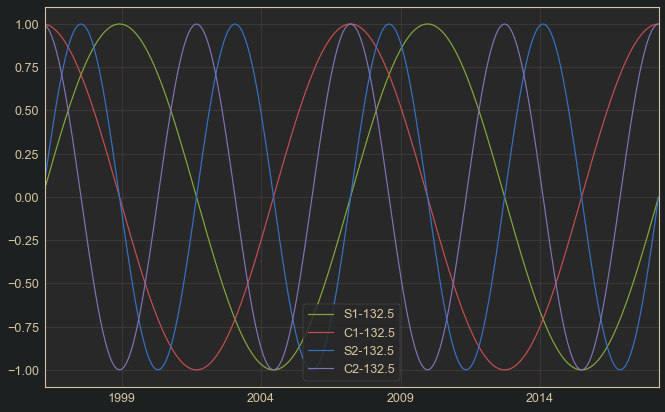

In [171]:
# A quick look at what we made
fs.plot()

In [ ]:
# We can see the first and second harmonics of sine and cosine here

In [168]:
# Fitting the simple model using a Fourier Series as exogenous predictors
fs = fourier_series(means_fix, freqs=[132.5], K=1)
model = SARIMAX(means_fix,
                order=(0,2,1),
                enforce_stationary=False,
                enforce_invertibility=False,
                exog=fs
               ).fit()
print(model.summary())

                           Statespace Model Results                           
Dep. Variable:             mean price   No. Observations:                  265
Model:               SARIMAX(0, 2, 1)   Log Likelihood               -1855.174
Date:                Mon, 03 Aug 2020   AIC                           3718.348
Time:                        12:08:55   BIC                           3732.637
Sample:                    04-01-1996   HQIC                          3724.091
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
S1-132.5   -7169.6188   1.07e+04     -0.668      0.504   -2.82e+04    1.39e+04
C1-132.5    1.748e+04   1.38e+04      1.264      0.206   -9620.208    4.46e+04
ma.L1         -0.0956      0.020     -4.742      0.0

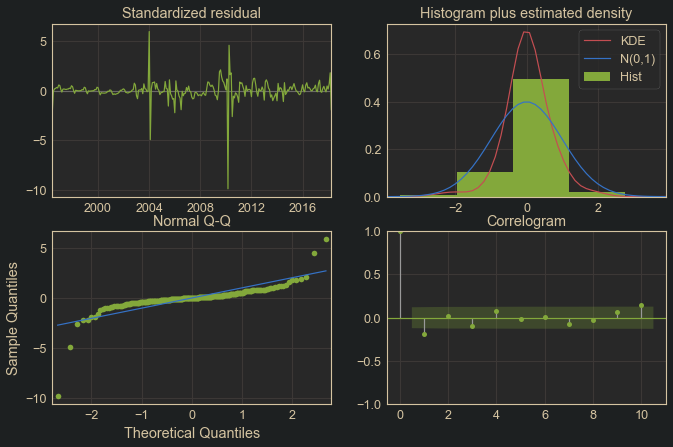

In [169]:
# We can see that the fourier terms did not aid the model in this case, and has insignificant
# coefficients. This all may come in handy for future datasets, however.
model.plot_diagnostics(figsize=(11,7));

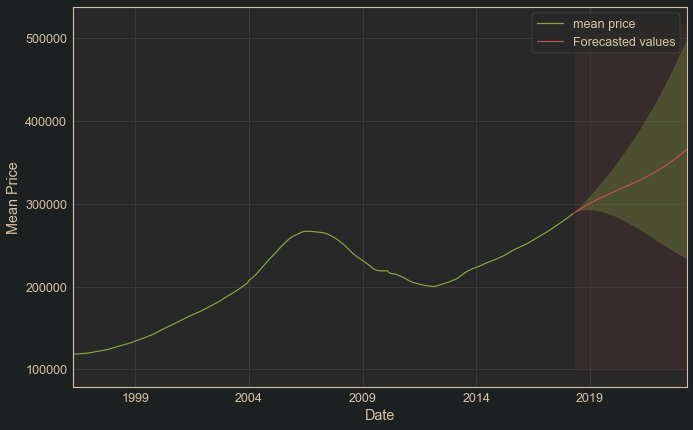

In [171]:
# Let's see now how the 5 year projection looks
prediction = model.get_forecast(60, exog=fourier_series(means_fix, freqs=[132.5], K=1, h=60))

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()
# Plot future predictions with confidence intervals
ax = means_fix.plot(label='observed')
prediction.predicted_mean.plot(label='Forecasted values', ax=ax)

ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1],
                alpha=0.3
               )

ax.fill_betweenx(ax.get_ylim(), pred_conf.index[0], pred_conf.index[-1],
                 alpha=0.1,
                 zorder=-1
                )

ax.set_xlabel('Date')
ax.set_ylabel('Mean Price')
plt.legend()
plt.show()

That function is working properly, although it does not seem to be useful so far. It should prove useful in the future.<br>
<br>
The second function to get use of in python is the auto.arima() function, also from the 'forecast' package in R. This function is optimized to find the best fitting SARIMA model to data, without having to do a stepwise grid search. This can save a lot of time when generating multiple models.

In [172]:
rlist = FloatVector(means_fix['mean price'])

In [173]:
rmodel = r['auto.arima'](rlist, 
                        #seasonal='TRUE'
                       )

In [174]:
print(rmodel)

Series: c(118299.123063432, 118419.044139141, 118537.42326805, 118653.069277989,  118780.254311605, 118927.528500438, 119120.520315697, 119345.352236188,  119685.084770535, 120121.26571178, 120544.241449868, 120896.623794212,  121268.174510377, 121655.897398422, 122053.105817013, 122456.339057362,  122879.926927293, 123327.402265254, 123823.105590062, 124353.737668981,  125002.601388381, 125736.669832688, 126450.778110616, 127086.25703222,  127736.362972163, 128385.014977716, 129032.702564477, 129676.357127201,  130324.519617155, 130982.618543143, 131678.088697304, 132399.342441733,  133224.702272229, 134133.593921239, 135020.881128078, 135841.586907284,  136683.794841821, 137532.147293052, 138391.809746475, 139265.156718054,  140160.604953606, 141084.832322642, 142070.095711259, 143104.04033024,  144261.328267699, 145522.064732958, 146772.26565354, 147943.683787536,  149107.817637174, 150247.760648791, 151364.608752831, 152457.017607949,  153530.934463359, 154597.187111858, 155691.101

We can see that this has worked, and that the parameters of the model can be seen. The output is a little messy, and it turns out that the tuple of parameters is simple to extract from the output. Luckily, converting the entire output to a string first aids the process:

In [175]:
# Extracting the model parameters:
string = str(rmodel).split('ARIMA')[1].split(' ')[0]
param = tuple(int(x) for x in string.replace('(','').replace(')','').split(','))
print(param)

(0, 2, 1)


In [176]:
# Fitting the simple model using the optimal parameters found by the auto.arima() function:
model = SARIMAX(means_fix,
                order=param,
                #seasonal_order=(0,2,3,4),
                enforce_stationary=False,
                enforce_invertibility=False,
                exog=fs
               ).fit()
print(model.summary())

                           Statespace Model Results                           
Dep. Variable:             mean price   No. Observations:                  265
Model:               SARIMAX(0, 2, 1)   Log Likelihood               -1855.174
Date:                Mon, 03 Aug 2020   AIC                           3718.348
Time:                        12:10:25   BIC                           3732.637
Sample:                    04-01-1996   HQIC                          3724.091
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
S1-132.5   -7169.6188   1.07e+04     -0.668      0.504   -2.82e+04    1.39e+04
C1-132.5    1.748e+04   1.38e+04      1.264      0.206   -9620.208    4.46e+04
ma.L1         -0.0956      0.020     -4.742      0.0

#### Notes:
We have now managed to get the parameter optimizing power of auto.arima() function from R into a python workflow, which means that it will be possible to generate seperate models for each of the zipcodes, which will allow for more flexibility.

### ARIMA Modeling on Returns

In [172]:
rlist = FloatVector(log_returns['returns'])

In [173]:
rmodel = r['auto.arima'](rlist, 
                        #seasonal='TRUE'
                       )

In [174]:
print(rmodel)

Series: c(0.00101319714819503, 0.000999163602102726, 0.000975131995057055,  0.00107133273339954, 0.00123911977921232, 0.00162145296717675,  0.00188565336166846, 0.00284258998446596, 0.00363778041225871,  0.00351505438886512, 0.00291899711504762, 0.00306857982923425,  0.00319213500934801, 0.00325969713934349, 0.00329830699272371,  0.00345312413668708, 0.00363495134065595, 0.00401135319368429,  0.00427624818301453, 0.00520432074347887, 0.00585524986142794,  0.00566332854708662, 0.00501291854273234, 0.00510243047009773,  0.00506520305003377, 0.00503220182146258, 0.00497590530107139,  0.00498585882309932, 0.00503698691141352, 0.00529559054903039,  0.00546245496814812, 0.00621451636790482, 0.00679907946199698,  0.00659316863196935, 0.00605996317417556, 0.00618078661375954,  0.00618749698672438, 0.00623117502512827, 0.00629085495611648,  0.00640922508700648, 0.00657241379588669, 0.00695921043553049,  0.00725135290256773, 0.00805451401263291, 0.00870128827359373,  0.00855444950243189, 0.00794

In [175]:
# Extracting the model parameters:
string = str(rmodel).split('ARIMA')[1].split(' ')[0]
param = tuple(int(x) for x in string.replace('(','').replace(')','').split(','))
print(param)

(0, 1, 1)


In [180]:
# Fitting the simple model using the optimal parameters found by the auto.arima() function:
model = SARIMAX(log_returns,
                order=param,
                #seasonal_order=(0,2,3,4),
                enforce_stationary=False,
                enforce_invertibility=False,
                #exog=fs
               ).fit()
print(model.summary())

                           Statespace Model Results                           
Dep. Variable:                returns   No. Observations:                  264
Model:               SARIMAX(0, 1, 1)   Log Likelihood                1382.393
Date:                Tue, 11 Aug 2020   AIC                          -2760.786
Time:                        19:03:13   BIC                          -2753.642
Sample:                    05-01-1996   HQIC                         -2757.915
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2868      0.027    -10.584      0.000      -0.340      -0.234
sigma2      1.587e-06   3.55e-08     44.646      0.000    1.52e-06    1.66e-06
Ljung-Box (Q):                       30.72   Jarque-

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [ ]:
# We can see that the null hypothesis of the Ljung-Box test of non-autocorrelated residuals is
# not rejected
# The null hypothesis of no heteroscedasticity is rejected
# The residuals do not appear to be normal

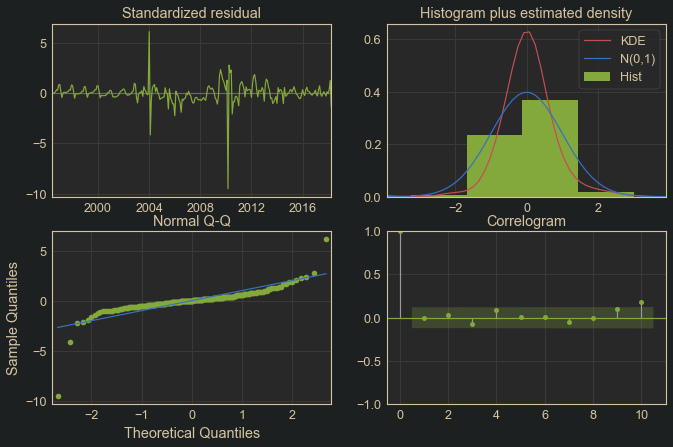

In [181]:
model.plot_diagnostics();

### Filtering Heteroscedasticity:
As Stockhammer & Oller (2007) state in their paper, "the most straightforward way to remove heteroscedasticity in [a time series] is to divide the heteroscedastic series by the conditional volatility estimated from ARCH/GARCH models or from any of their many generalizations."<br>
<br>
Following this advice, I will now fit a ARCH/GARCH model to the residuals from our best model so far, an ARIMA(0,2,1)

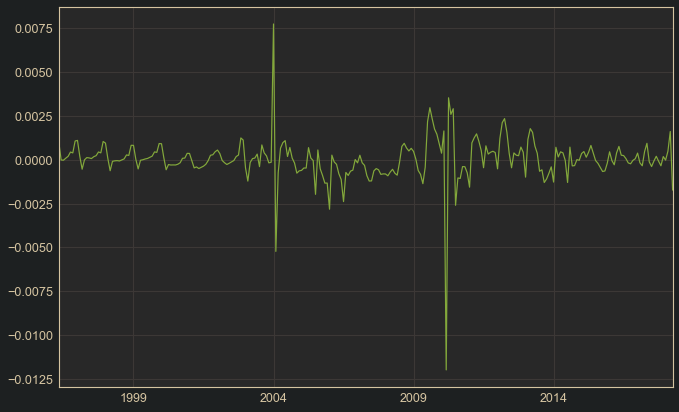

In [182]:
# A look at a plot of the residuals
model.resid.plot()

In [183]:
# We can see that the first 2 residual values are huge, this is due to the second-order
# differencing that the model requires, which takes 2 steps to come into effect.
model.resid

1996-05-01    0.001013
1996-06-01   -0.000014
1996-07-01   -0.000028
1996-08-01    0.000088
1996-09-01    0.000193
                ...   
2017-12-01    0.000181
2018-01-01   -0.000024
2018-02-01    0.000490
2018-03-01    0.001610
2018-04-01   -0.001724
Length: 264, dtype: float64

In [184]:
model.resid.mean()

2.9343062601187136e-05

In [323]:
# We can see that the residuals have a very near-zero mean

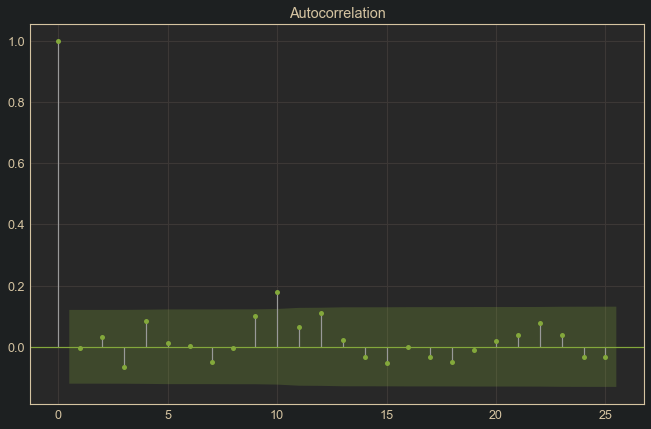

In [185]:
plot_acf(model.resid);

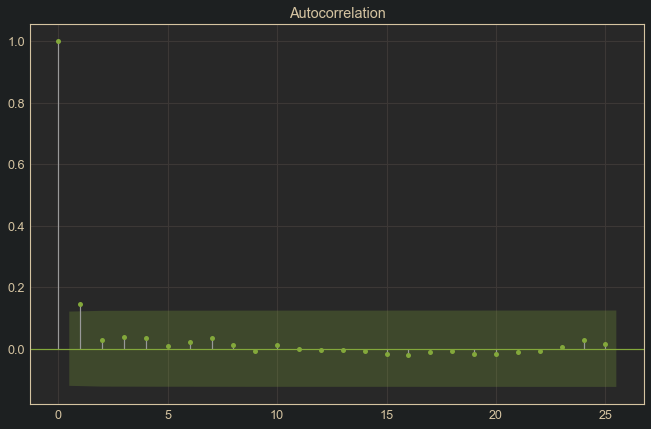

In [186]:
# To test autocorrelation of variance, we need to square these values. Also, when looking at the
# residuals, any autocorrelation is going to occur over a large number of lags, so we need to
# expand the range of lags we are looking at
plot_acf(model.resid**2, 
         #lags=len(model.resid[2:])/2
        );

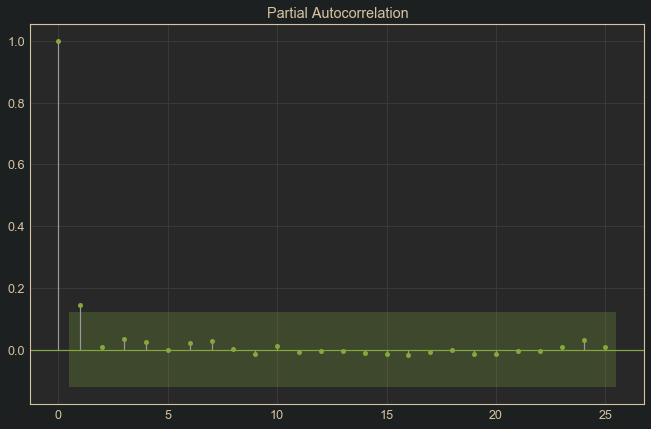

In [239]:
plot_pacf(model.resid**2);

In [187]:
# We can see that there does seem to be some autocorrelation at 1 lag
# There might be something to this, considering that this is not a convenient factor of the
# length of the dataset

In [188]:
from statsmodels.stats.diagnostic import het_arch

In [189]:
# Performing ARCHA-LM test, note that recommended ddof = (p+q) from ARIMA model
results = het_arch(model.resid, 
                   #maxlag=80, 
                   ddof=1
                  )
res_names = ['LM test statistic', 'LM p-value', 'F-statistic', 'F-test p-value']
results = list(zip(res_names, results))
results

[('LM test statistic', 6.061209762072162),
 ('LM p-value', 0.9874207138904765),
 ('F-statistic', 0.3616977494756379),
 ('F-test p-value', 0.9892646001020178)]

The null hypothesis of no autocorrelated heteroscedasticity is not rejected, which isn't quite surprising considering that there are just a couple huge spikes of volatility which don't really establish a time-dependent relationship in the data. This problem is reminiscent of the one I ran into with trying to model the long-term siniusoidal trending of the market. The areas of heightened volatility may be too abrupt and abnormal to model with an ARCH/GARCH approach.

In [190]:
from arch import arch_model

In [248]:
# define model
arch = arch_model(model.resid, 
                  mean='Zero', 
                  vol='GARCH', 
                  #dist='t'
                  rescale=False
                 ).fit()

Iteration:      1,   Func. Count:      5,   Neg. LLF: -1424.197980166941
Iteration:      2,   Func. Count:     14,   Neg. LLF: -1425.1724689614948
Iteration:      3,   Func. Count:     21,   Neg. LLF: -1425.7133560016816
Iteration:      4,   Func. Count:     29,   Neg. LLF: -1425.7184381858742
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1425.7184382739742
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 4


In [249]:
arch.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.004
Vol Model:                      GARCH   Log-Likelihood:                1425.72
Distribution:                  Normal   AIC:                          -2845.44
Method:            Maximum Likelihood   BIC:                          -2834.71
                                        No. Observations:                  264
Date:                Tue, Aug 11 2020   Df Residuals:                      261
Time:                        19:25:23   Df Model:                            3
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      2.0120e-07  3.504e-10    574.261      0.000 [2.005e-07,2.019e-07]
alpha[1]       0.2346      0.239      0.981      0.326     [ -0.234,  0.703]
beta[1]        0.7130      0.140      5.097  3.459e-07     [  0.439,  0.987]
============================================================================

Covariance estimator: robust
"""

In [250]:
# While these coefficients are similar to those produced in the R notebook, the
# standard errors are different.

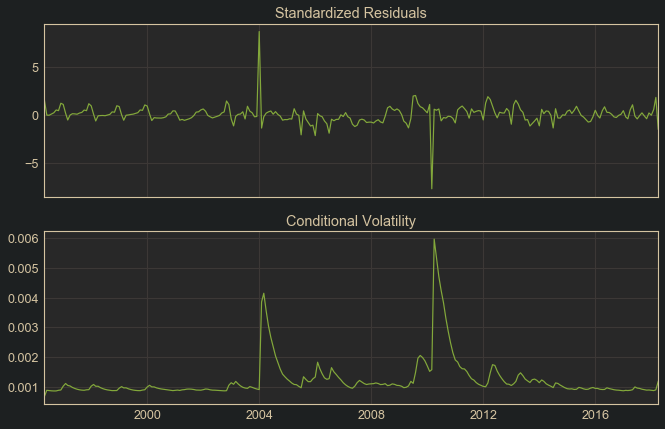

In [251]:
arch.plot();

In [252]:
len(arch.conditional_volatility)

264

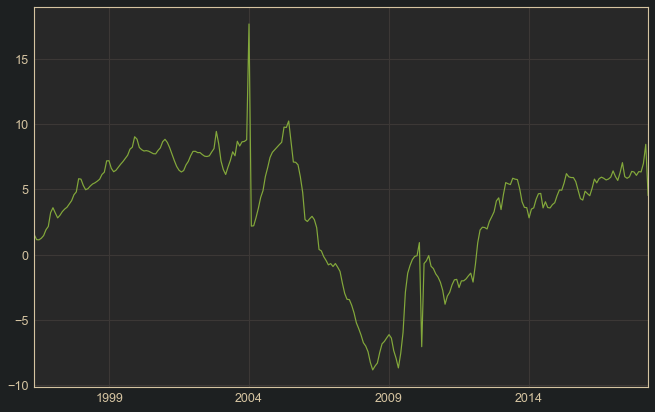

In [253]:
test = log_returns.returns / arch.conditional_volatility
test.plot()

#### Notes so far:
I do not see the advantage of dividing the original series by the output of the GARCH model, I have probably not implemented this properly. It was refreshing to see that the coefficients of the GARCH model here are similar to those generated from the rugarch package in R. All in all, I think that the workflow I have come up with in R is better and outperforms the workflow I've used in this notebook. For one thing, the grid searching in python has proven to be bugging for some reason, and is very slow. In comparison, R has the auto.arima() function, which is very efficient, and generally performs well. Second of all, the rugarch package provides a comprehensive set of functions for fitting the mean and volatility models together, and even uses the ARCH in mean functionality. The graphs generated by the rugarch package are also far more comprehensive.

### Removing the heteroscedasticity by limiting time window

Since the investigation into using fourier terms on this dataset revealed that they will not be useful to model any long-term seasonality of the market, and because the circumstances that led to the 2007 market crash are probably more unique than they are seasonal, I have decided that the best choice moving forward would be to remove data the data before and during the crash, and focus on the price data after all of the drama subsided.<br>
<br>
Let's look again at the plot of the price means to see where a good cutoff point might be:

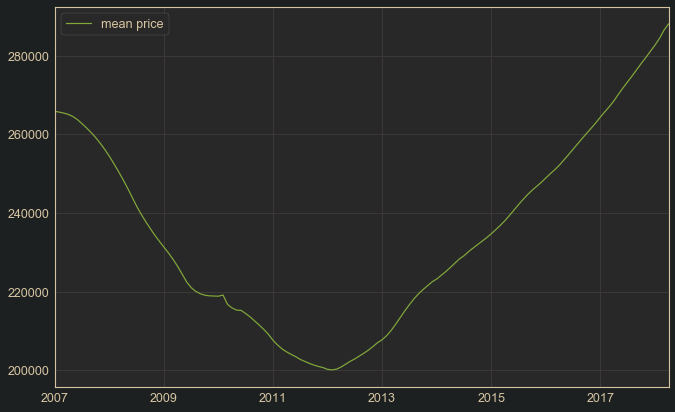

In [177]:
means_fix['2007':].plot(figsize=(11,7))

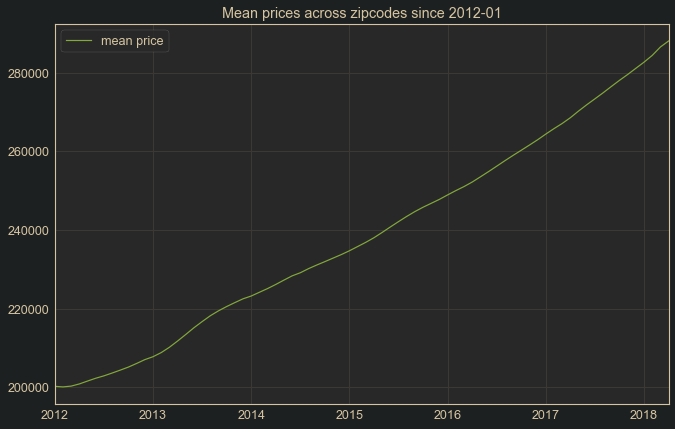

In [178]:
# It looks like the beginning of 2012 would make a good cutoff point, let's see that:
means_fix['2012':].plot(figsize=(11,7))
plt.title("Mean prices across zipcodes since 2012-01");

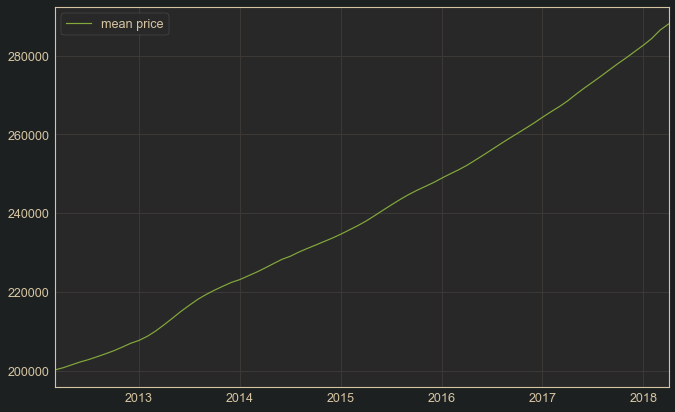

In [179]:
# This still has a bit of a dip in it, I will index a bit further into 2012
means_fix['2012-03':].plot(figsize=(11,7))

In [180]:
# This looks pretty uniform. Let's see how an arima model looks for this data
means_trim = means_fix['2012-03':]
rlist = FloatVector(means_trim['mean price'])
rmodel = r['auto.arima'](rlist)
print(rmodel)

Series: c(200272.349817229, 200824.656872888, 201558.155734878, 202274.412028416,  202879.534339051, 203592.28490735, 204337.92105807, 205118.247571812,  206036.550251429, 207004.656609492, 207745.450178424, 208791.545429591,  210145.42272852, 211730.785067252, 213399.382377162, 215113.127916552,  216674.798138771, 218163.500752703, 219413.008074449, 220509.586697687,  221509.880936089, 222473.737511975, 223183.207199836, 224135.937819595,  225082.573123338, 226124.783527647, 227232.010636122, 228310.622485853,  229099.280038036, 230141.74420974, 231060.035318889, 231927.514772804,  232822.135434354, 233712.307274333, 234691.190654079, 235760.279834273,  236836.426000136, 238009.760239082, 239354.207702235, 240744.121442641,  242103.525096787, 243424.444746315, 244658.269374448, 245764.565645589,  246765.041092169, 247765.170141955, 248896.366229709, 249987.312368403,  251014.310942063, 252164.273585546, 253483.637845548, 254820.084221966,  256205.780071996, 257597.914827141, 258946.02

In [181]:
# Extracting the model parameters:
string = str(rmodel).split('ARIMA')[1].split(' ')[0]
param = tuple(int(x) for x in string.replace('(','').replace(')','').split(','))
print(param)

# Making an equivalent model in StatsModels
model = SARIMAX(means_trim,
                order=param,
                #seasonal_order=(0,2,3,4),
                enforce_stationary=False,
                enforce_invertibility=False
               ).fit()
print(model.summary())

(0, 2, 0)
                           Statespace Model Results                           
Dep. Variable:             mean price   No. Observations:                   74
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -464.546
Date:                Mon, 03 Aug 2020   AIC                            931.093
Time:                        12:11:00   BIC                            933.370
Sample:                    03-01-2012   HQIC                           931.999
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.352e+04   2521.377      9.329      0.000    1.86e+04    2.85e+04
Ljung-Box (Q):                       23.51   Jarque-Bera (JB):                33.05
Prob(Q):                             

In [182]:
# The null hypothesis of the Ljung-Box test that the errors are not autocorrelated is not 
# rejected.
# The null hypothesis of the Heteroskedasticity test that the variance is not changing
# throughout the sample is not rejected.
# The null hypothesis of normal skew and kurtosis of the residuals is rejected, but a 
# visual inspection of the histogram of residuals indicates they are normal enough, the issue
# is the kurtosis being too high, meaning long tails

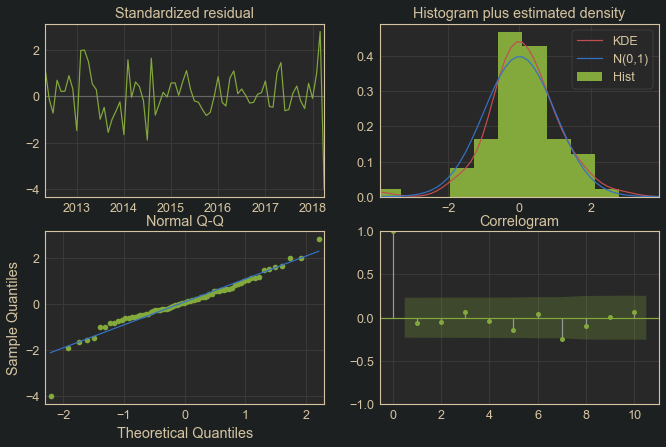

In [183]:
# Checking diagnostics of new model:
model.plot_diagnostics(figsize=(11,7));

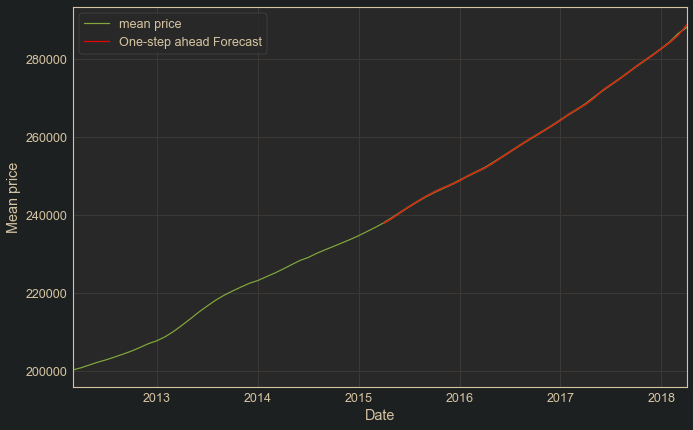

In [364]:
# Get predictions
pred = model.get_prediction('2015-04', '2018-04', dynamic=False)
pred_conf = pred.conf_int()
# Plot observed values
ax = means_trim.plot(label='observed')
# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', color='red', alpha=0.9)
# Plot the range for confidence intervals
ax.fill_between(pred_conf.index, 
                pred_conf.iloc[:, 0], 
                pred_conf.iloc[:, 1],
                alpha=0.5
               )
# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Mean price')
plt.legend()
plt.show()

In [365]:
# We can see the one-step-ahead predictions of this model are pretty spot on, which isn't 
# surprising considering the smooth linear data. Let's look at the MSE
forecasted = pred.predicted_mean
truth = means_trim['2015-04':'2018-04']['mean price']

# Compute the mean square error
mse = np.mean((forecasted - truth) ** 2)
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 23522.72


In [ ]:
# This error is pretty good, considering the scale we are considering is in the hundreds of
# thousands

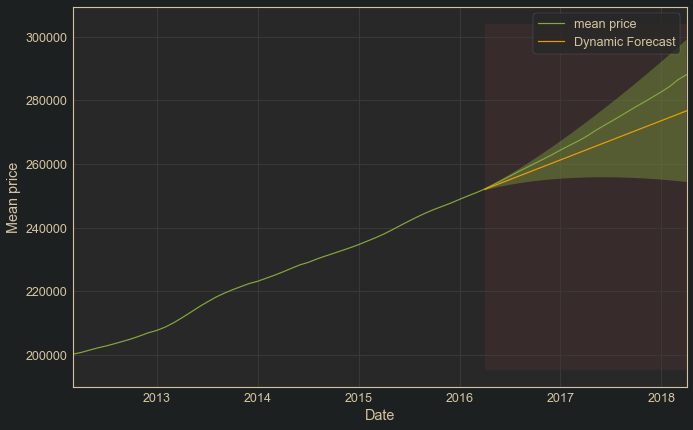

In [366]:
# Get dynamic predictions with confidence intervals
pred_dynamic = model.get_prediction(start='2016-04', end='2018-04', dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

# Plot observed values
ax = means_trim.plot(label='observed')
# Plot predicted values
pred_dynamic.predicted_mean.plot(ax=ax, label='Dynamic Forecast', color='orange', alpha=0.9)
# Plot the range for confidence intervals
ax.fill_between(pred_dynamic_conf.index, 
                pred_dynamic_conf.iloc[:, 0], 
                pred_dynamic_conf.iloc[:, 1],
                alpha=0.4
               )
ax.fill_betweenx(ax.get_ylim(), 
                 pd.to_datetime('2016-04'), 
                pred_dynamic.predicted_mean.index[-1],
                alpha=0.1,
                zorder=-1
               )
# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Mean price')
plt.legend()
plt.show()

In [ ]:
# The predictions here are a bit conservative, but the slope does increase a bit during the
# period which was isolated from the training data.

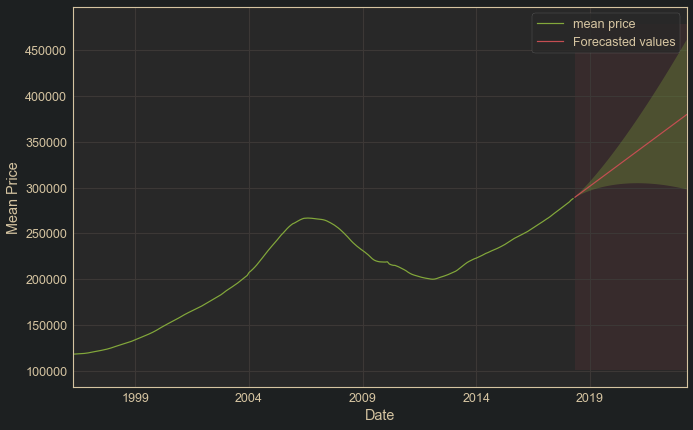

In [368]:
# Let's see now how the 5 year projection looks
prediction = model.get_forecast(60)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()
# Plot future predictions with confidence intervals
ax = means_fix.plot(label='observed')
prediction.predicted_mean.plot(label='Forecasted values', ax=ax)

ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1],
                alpha=0.3
               )

ax.fill_betweenx(ax.get_ylim(), pred_conf.index[0], pred_conf.index[-1],
                 alpha=0.1,
                 zorder=-1
                )

ax.set_xlabel('Date')
ax.set_ylabel('Mean Price')
plt.legend()
plt.show()

In [ ]:
# These results are fairly reminiscent of the facebook prophet projections, although the low end
# is a bit more optimistic, probably because the training data only considered an upward trend

In [369]:
# I am wondering how this model, which had no AR or MA terms, compares to one which has at least
# one MA term
# Let's try another basic model, this time with pdq of (0, 2, 1)
model = SARIMAX(means_trim,
                order=(0,2,1),
                #seasonal_order=(0,2,3,4),
                enforce_stationary=False,
                enforce_invertibility=False
               ).fit()
print(model.summary())

                           Statespace Model Results                           
Dep. Variable:             mean price   No. Observations:                   74
Model:               SARIMAX(0, 2, 1)   Log Likelihood                -463.789
Date:                Sun, 02 Aug 2020   AIC                            931.578
Time:                        17:16:59   BIC                            936.131
Sample:                    03-01-2012   HQIC                           933.391
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0406      0.085     -0.476      0.634      -0.208       0.126
sigma2      2.404e+04   3203.115      7.505      0.000    1.78e+04    3.03e+04
Ljung-Box (Q):                       23.93   Jarque-

In [ ]:
# We can see that the performance is nearly identical, with only a little improvement on the 
# log likelihood and JB scores.
# It can be seen that the p-value for the MA term is far from significant, reinforcing the fact
# that the last model was ideal. This also reinforces the selection of the auto.arima() function

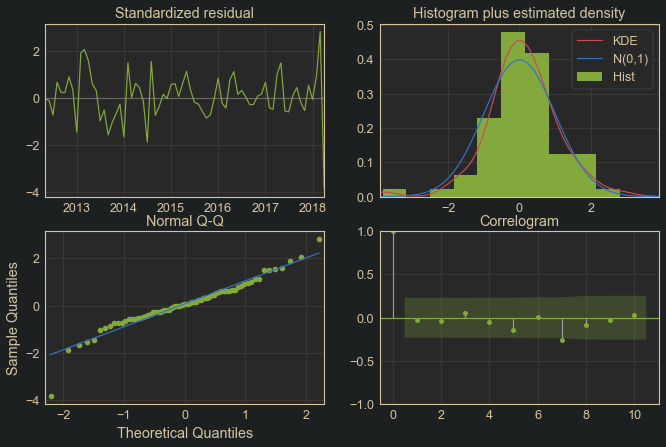

In [370]:
# Checking diagnostics of new model:
model.plot_diagnostics(figsize=(11,7));

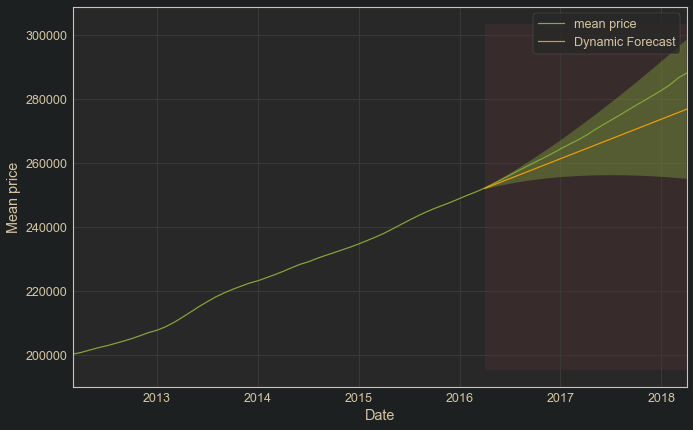

In [371]:
# Get dynamic predictions with confidence intervals
pred_dynamic = model.get_prediction(start='2016-04', end='2018-04', dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

# Plot observed values
ax = means_trim.plot(label='observed')
# Plot predicted values
pred_dynamic.predicted_mean.plot(ax=ax, label='Dynamic Forecast', color='orange', alpha=0.9)
# Plot the range for confidence intervals
ax.fill_between(pred_dynamic_conf.index, 
                pred_dynamic_conf.iloc[:, 0], 
                pred_dynamic_conf.iloc[:, 1],
                alpha=0.4
               )
ax.fill_betweenx(ax.get_ylim(), 
                 pd.to_datetime('2016-04'), 
                pred_dynamic.predicted_mean.index[-1],
                alpha=0.1,
                zorder=-1
               )
# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Mean price')
plt.legend()
plt.show()

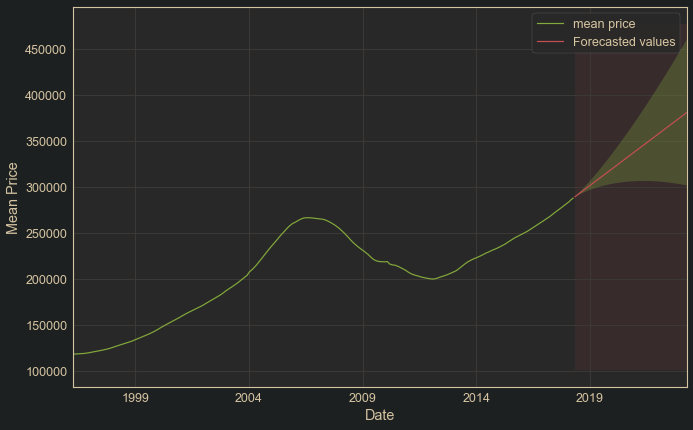

In [372]:
# Let's see now how the 5 year projection looks
prediction = model.get_forecast(60)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()
# Plot future predictions with confidence intervals
ax = means_fix.plot(label='observed')
prediction.predicted_mean.plot(label='Forecasted values', ax=ax)

ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1],
                alpha=0.3
               )

ax.fill_betweenx(ax.get_ylim(), pred_conf.index[0], pred_conf.index[-1],
                 alpha=0.1,
                 zorder=-1
                )

ax.set_xlabel('Date')
ax.set_ylabel('Mean Price')
plt.legend()
plt.show()